This notebook is aimed at summarising output from BiG-SLICE (Kautsar et al. 2021) but also relies on output from the MetaSing pipeline, namely GTDB-tk (Chaumeil et al. 2021)
<br>
<br>
Geneious Prime was used for amino acid sequence alignment of the CCC RiPPs described here. Note that CCC is a naming convention and this motif can vary in select cases. As outlined in the thesis another group was found to be working on this at the same time. (Nguyen et al. 2021)
<br>
<br>
References:
<br>
Chaumeil, P. A., Mussig, A. J., Hugenholtz, P., & Parks, D. H. (2020). GTDB-Tk: a toolkit to classify genomes with the Genome Taxonomy Database.
<br>
Kautsar, S. A., van der Hooft, J. J., de Ridder, D., & Medema, M. H. (2021). BiG-SLiCE: A highly scalable tool maps the diversity of 1.2 million biosynthetic gene clusters. Gigascience, 10(1), giaa154.
<br>
Nguyen, N. A., Lin, Z., Mohanty, I., Garg, N., Schmidt, E. W., & Agarwal, V. (2021). An obligate peptidyl brominase underlies the discovery of highly distributed biosynthetic gene clusters in marine sponge microbiomes. Journal of the American Chemical Society, 143(27), 10221-10231.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import pickle
import os
import fnmatch
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO

## Explore table structure
## Make sure correct cursor is connected when running analyses!

In [2]:
# Prints the names of all the tables
# cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
# Neat format
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/result/data.db") as con:
    cur = con.cursor()

for i in cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall():
    print(i[0])

bgc
sqlite_sequence
bgc_class
bgc_features
bgc_taxonomy
cds
chem_class
chem_subclass
chem_subclass_map
clustering
dataset
enum_bgc_type
enum_run_status
gcf
gcf_membership
gcf_models
hmm
hmm_db
hsp
hsp_alignment
hsp_subpfam
run
run_bgc_status
run_log
schema
subpfam
taxon
taxon_class


In [3]:
cur.execute("PRAGMA table_info('run')").fetchall()

[(0, 'id', 'INTEGER', 0, None, 1),
 (1, 'status', 'INTEGER', 1, None, 0),
 (2, 'prog_params', 'VARCHAR(250)', 1, None, 0),
 (3, 'hmm_db_id', 'INTEGER', 0, None, 0)]

In [4]:
# Table that shows what run status (see below) BGCs achieved in each of the runs
# run_bgc_status['run_id'] values in table are any of the following {1, 2, 3, 4, 5, 6, 7, 8}
# run_bgc_status['status'] values in table are any of the following {1, 2, 7}
cur.execute("PRAGMA table_info('run_bgc_status')").fetchall()

[(0, 'bgc_id', 'INTEGER', 1, None, 0),
 (1, 'run_id', 'INTEGER', 1, None, 0),
 (2, 'status', 'INTEGER', 1, None, 0)]

In [5]:
# with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/result/data.db") as con:
#     cur = con.cursor()
#     bgc_id, run_id, status  = tuple(zip(*cur.execute(
#         "select bgc_id, run_id, status from run_bgc_status order by bgc_id asc").fetchall()))
#     run_bgc_status = pd.DataFrame(
#         {
#             "bgc_id": bgc_id,
#             "run_id": run_id,
#             "status": status,
#         },
#         index=bgc_id
#     )

In [6]:
# Small table for run status (RUN_STARTED, BIOSYN_SCANNED, SUBPFAM_SCANNED, etc.)
cur.execute("PRAGMA table_info('enum_run_status')").fetchall()

[(0, 'id', 'INTEGER', 0, None, 1), (1, 'name', 'VARCHAR(100)', 1, None, 0)]

In [7]:
# with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/result/data.db") as con:
#     cur = con.cursor()
#     id, name  = tuple(zip(*cur.execute(
#         "select id, name from enum_run_status order by id asc").fetchall()))
#     enum_run_status = pd.DataFrame(
#         {
#             "id": id,
#             "name": name,
#         },
#         index=id
#     )

In [8]:
cur.execute("PRAGMA table_info('gcf_membership')").fetchall()

[(0, 'gcf_id', 'INTEGER', 1, None, 0),
 (1, 'bgc_id', 'INTEGER', 1, None, 0),
 (2, 'membership_value', 'INTEGER', 1, None, 0),
 (3, 'rank', 'INTEGER', 1, None, 0)]

## Collect background information from paper results

In [9]:
# Fetch BGC names
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/result/data.db") as con:
    cur = con.cursor()
    bgc_ids, genome_names, bgc_names, contig_edges, lengths, type  = tuple(zip(*cur.execute(
        "select id, orig_folder, name, on_contig_edge, length_nt, type from bgc order by id asc"
    ).fetchall()))
    bgc_meta = pd.DataFrame(
        {
            "genome": genome_names,
            "name": bgc_names,
            "fragmented": contig_edges,
            "length": lengths,
            "type": type
        },
        index=bgc_ids
    )


In [10]:
print(len(bgc_meta))
bgc_meta.head(10)

1225071


,genome,name,fragmented,length,type
1,,BGC0001286.1,0,16181,mibig
2,,BGC0000034.1,0,138203,mibig
3,,BGC0000686.1,0,16277,mibig
4,,BGC0001839.1,0,21215,mibig
5,,BGC0001522.1,0,126292,mibig
6,,BGC0000081.1,0,135420,mibig
7,,BGC0001537.1,0,68929,mibig
8,,BGC0000233.1,0,45603,mibig
9,,BGC0000614.1,0,29379,mibig
10,,BGC0001026.1,0,19818,mibig


In [11]:
# 0 stands for "not on contig edge"
len(bgc_meta[bgc_meta["fragmented"] == 0])

802287

In [12]:
# Find out length of types, in particular number of MiBIG BGCs
print(set(bgc_meta["type"].tolist()))
print(len(bgc_meta[bgc_meta["type"] == 'as5']))
print(len(bgc_meta[bgc_meta["type"] == 'mibig']))

{'mibig', 'as5'}
1223161
1910


In [13]:
# fetching chem_subclass_map for later merging
cur = con.cursor()
subclass_id, class_source, type_source = tuple(zip(*cur.execute(
    "select subclass_id, class_source, type_source from chem_subclass_map order by subclass_id asc"
).fetchall()))
chem_subclass_map_df = pd.DataFrame(
    {
        "class_source": class_source,
        "type_source": type_source,
    },
    index=subclass_id
)

In [14]:
print(set(chem_subclass_map_df['type_source'].tolist()))
chem_subclass_map_df.head(10)

{'as4', 'mibig', 'plant', 'as5'}


,class_source,type_source
2,lassopeptide,as4
3,nrps,as4
4,acyl_amino_acids,as4
5,arylpolyene,as4
6,cf_fatty_acid,as4
7,other,as4
8,otherks,as4
9,ppysks,as4
10,t1pks,as4
11,t2pks,as4


In [15]:
# Extract BGC taxonomy table
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/result/data.db") as con:
    cur = con.cursor()
    bgc_ids, taxon_id = tuple(zip(*cur.execute(
        "select bgc_id, taxon_id from bgc_taxonomy"
    ).fetchall()))
    bgc_taxonomy = pd.DataFrame(
        {
            "taxon_id": taxon_id,
        },
        index=bgc_ids
    )
    #gcf_membership.to_pickle(bigslice_names)

In [16]:
bgc_taxonomy.head(10)

,taxon_id
1,1
1,2
1,3
1,4
1,5
1,6
1,7
2,8
2,9
2,10


In [17]:
# Extract taxonomy id to name table
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/result/data.db") as con:
    cur = con.cursor()
    ids, level, name = tuple(zip(*cur.execute(
        "select id, level, name from taxon"
    ).fetchall()))
    taxon = pd.DataFrame(
        {
            "level": level,
            "name": name,
        },
        index=ids
    )

In [18]:
taxon.head(10)

,level,name
1,0,Fungi
2,1,Basidiomycota
3,2,Ustilaginomycetes
4,3,Ustilaginales
5,4,Ustilaginaceae
6,5,Ustilago
7,6,Ustilago maydis
8,0,Bacteria
9,1,Actinobacteria
10,2,Actinobacteria


In [19]:
print(len(bgc_taxonomy))
print(len(taxon))
bgc_taxonomy_full_df = pd.merge(bgc_taxonomy, taxon, how="left", left_on="taxon_id", right_index=True)
print(len(bgc_taxonomy_full_df[bgc_taxonomy_full_df["level"] == 0]))
print(len(bgc_taxonomy_full_df[bgc_taxonomy_full_df["level"] == 1]))
print(len(bgc_taxonomy_full_df[bgc_taxonomy_full_df["level"] == 2]))
print(len(bgc_taxonomy_full_df[bgc_taxonomy_full_df["level"] == 3]))
print(len(bgc_taxonomy_full_df[bgc_taxonomy_full_df["level"] == 4]))
bgc_taxonomy_full_df.head(10)


8494068
33035
1224579
1217902
1217623
1216368
1214162


,taxon_id,level,name
1,1,0,Fungi
1,2,1,Basidiomycota
1,3,2,Ustilaginomycetes
1,4,3,Ustilaginales
1,5,4,Ustilaginaceae
1,6,5,Ustilago
1,7,6,Ustilago maydis
2,8,0,Bacteria
2,9,1,Actinobacteria
2,10,2,Actinobacteria


In [20]:
# # This catches the GCF membership of all the BGCs reported in the paper
# # NOTE THAT THIS TAKES >40 MIN AND IS NOT NEEDED FOR THE NOTEBOOK TO RUN
# # For reference, the paper mentions 121299 GCF centroids discovered
# # fetching gcf_membership
# cur = con.cursor()
# bgc_ids, gcf_id, membership_value, rank = tuple(zip(*cur.execute(
#     "select bgc_id, gcf_id, membership_value, rank from gcf_membership order by bgc_id asc"
# ).fetchall()))
# gcf_membership = pd.DataFrame(
#     {
#         "gcf_id": gcf_id,
#         "membership_value": membership_value,
#         "rank": rank,
#     },
#     index=bgc_ids
# )
# #gcf_membership.to_pickle(bigslice_names)

### Report 3 with bigslice_v1.sif and --query_name T300_v3 --n_ranks 3 --run_id 0002
### run_id 0002 used T=300

In [21]:
# fetch bgc names
#bigslice_names = "/home/vincent/Documents/bigslice_results_080920/result/cache/bigslice_names.pkl"
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/reports/3/data.db") as con:
    cur = con.cursor()
    bgc_ids, genome_names, bgc_names, contig_edges, lengths, type  = tuple(zip(*cur.execute(
        "select id, orig_folder, name, on_contig_edge, length_nt, type from bgc order by id asc"
    ).fetchall()))
    bgc_meta_report3 = pd.DataFrame(
        {
            "genome": genome_names,
            "name": bgc_names,
            "fragmented": contig_edges,
            "length": lengths,
            "type": type
        },
        index=bgc_ids
    )
    #bgc_meta.to_pickle(bigslice_names)

In [22]:
print(len(bgc_meta_report3))
bgc_meta_report3.head(10)

2670


,genome,name,fragmented,length,type
1,./bigslice_080920/dataset_NZ/MHpat150,./bigslice_080920/dataset_NZ/MHpat150/c03486_N...,1,8390,as5
2,./bigslice_080920/dataset_NZ/MHs1,./bigslice_080920/dataset_NZ/MHs1/c02002_NODE_...,1,7193,as5
3,./bigslice_080920/dataset_Ton/CS203,./bigslice_080920/dataset_Ton/CS203/c01674_NOD...,1,12210,as5
4,./bigslice_080920/dataset_Ton/CS200,./bigslice_080920/dataset_Ton/CS200/c00493_NOD...,0,21753,as5
5,./bigslice_080920/dataset_Ton/CS211,./bigslice_080920/dataset_Ton/CS211/c07221_NOD...,1,10593,as5
6,./bigslice_080920/dataset_Ton/CS211,./bigslice_080920/dataset_Ton/CS211/c00364_NOD...,0,10288,as5
7,./bigslice_080920/dataset_Ton/CS202,./bigslice_080920/dataset_Ton/CS202/c00371_NOD...,0,10873,as5
8,./bigslice_080920/dataset_Med/Aplysina,./bigslice_080920/dataset_Med/Aplysina/c01341_...,0,10846,as5
9,./bigslice_080920/dataset_Ton/CS783,./bigslice_080920/dataset_Ton/CS783/c06228_NOD...,1,8228,as5
10,./bigslice_080920/dataset_NZ/0977,./bigslice_080920/dataset_NZ/0977/c03481_NODE_...,1,17901,as5


In [23]:
# fetching gcf_membership
cur = con.cursor()
bgc_ids, gcf_id, membership_value, rank = tuple(zip(*cur.execute(
    "select bgc_id, gcf_id, membership_value, rank from gcf_membership order by bgc_id asc"
).fetchall()))
gcf_membership_3 = pd.DataFrame(
    {
        "gcf_id": gcf_id,
        "membership_value": membership_value,
        "rank": rank,
    },
    index=bgc_ids
)
#gcf_membership.to_pickle(bigslice_names)

In [24]:
# Quantify how many core members, orphan members
# In paper “core” (d ≤ T), “putative” (T < d ≤ 2T), or “orphan” (d > 2T) -> 2T = 600
print(len(gcf_membership_3[(gcf_membership_3["rank"] == 0) & (gcf_membership_3["membership_value"] < 300)]))
print(len(gcf_membership_3[(gcf_membership_3["rank"] == 0) & (gcf_membership_3["membership_value"] >= 600)]))
print(len(gcf_membership_3[(gcf_membership_3["rank"] == 0) & (gcf_membership_3["membership_value"] >= 900)]))
print(len(gcf_membership_3[(gcf_membership_3["rank"] == 0) & (gcf_membership_3["membership_value"] >= 1800)]))


146
2076
1364
56


In [25]:
# What is the highest gcf_id? If a new GCF was formed, this should be >121299
print(gcf_membership_3["gcf_id"].max())
# How many GCFs were BGCs attributed to?
print("There were " + str(len(gcf_membership_3[gcf_membership_3["rank"] == 0]["gcf_id"].unique())) + " GCFs identified")


121294
There were 684 GCFs identified


### Combining report 3 and paper results

In [26]:
# Merge the dataframes but only take the rank == 0 GCF, i.e. highest confidence
bgc_meta_gcf_3 = pd.merge(bgc_meta_report3, gcf_membership_3[gcf_membership_3["rank"] == 0], how='inner', left_index=True, right_index=True)


In [27]:
print(len(bgc_meta_gcf_3))
bgc_meta_gcf_3.head(10)

2670


,genome,name,fragmented,length,type,gcf_id,membership_value,rank
1,./bigslice_080920/dataset_NZ/MHpat150,./bigslice_080920/dataset_NZ/MHpat150/c03486_N...,1,8390,as5,20945,716,0
2,./bigslice_080920/dataset_NZ/MHs1,./bigslice_080920/dataset_NZ/MHs1/c02002_NODE_...,1,7193,as5,10219,635,0
3,./bigslice_080920/dataset_Ton/CS203,./bigslice_080920/dataset_Ton/CS203/c01674_NOD...,1,12210,as5,16067,1028,0
4,./bigslice_080920/dataset_Ton/CS200,./bigslice_080920/dataset_Ton/CS200/c00493_NOD...,0,21753,as5,47428,1088,0
5,./bigslice_080920/dataset_Ton/CS211,./bigslice_080920/dataset_Ton/CS211/c07221_NOD...,1,10593,as5,108376,954,0
6,./bigslice_080920/dataset_Ton/CS211,./bigslice_080920/dataset_Ton/CS211/c00364_NOD...,0,10288,as5,13467,877,0
7,./bigslice_080920/dataset_Ton/CS202,./bigslice_080920/dataset_Ton/CS202/c00371_NOD...,0,10873,as5,82643,674,0
8,./bigslice_080920/dataset_Med/Aplysina,./bigslice_080920/dataset_Med/Aplysina/c01341_...,0,10846,as5,2393,22,0
9,./bigslice_080920/dataset_Ton/CS783,./bigslice_080920/dataset_Ton/CS783/c06228_NOD...,1,8228,as5,67016,671,0
10,./bigslice_080920/dataset_NZ/0977,./bigslice_080920/dataset_NZ/0977/c03481_NODE_...,1,17901,as5,118127,612,0


In [28]:
# fetching bgc_class
cur = con.cursor()
bgc_ids, chem_subclass_id = tuple(zip(*cur.execute(
    "select bgc_id, chem_subclass_id from bgc_class order by bgc_id asc"
).fetchall()))
chem_subclass_3 = pd.DataFrame(
    {
        "chem_subclass_id": chem_subclass_id
    },
    index=bgc_ids
)

In [29]:
# This shows that some BGCs have been assigned more than one chem_subclass -> aggregate later
print(len(chem_subclass_3))
print(len(set(chem_subclass_3.index.tolist())))
chem_subclass_3.head(10)

2741
2670


,chem_subclass_id
1,72
2,72
3,68
4,68
5,59
6,72
7,72
8,72
9,72
10,68


In [30]:
NP_class_df_3 = pd.merge(chem_subclass_3, chem_subclass_map_df, left_on="chem_subclass_id", right_index=True)
print(len(NP_class_df_3))
bgc_summary_df3 = pd.merge(bgc_meta_gcf_3, NP_class_df_3, right_index=True, left_index=True)
print(len(bgc_summary_df3))
bgc_summary_df3


2741
2741


,genome,name,fragmented,length,type,gcf_id,membership_value,rank,chem_subclass_id,class_source,type_source
1,./bigslice_080920/dataset_NZ/MHpat150,./bigslice_080920/dataset_NZ/MHpat150/c03486_N...,1,8390,as5,20945,716,0,72,bacteriocin,as5
2,./bigslice_080920/dataset_NZ/MHs1,./bigslice_080920/dataset_NZ/MHs1/c02002_NODE_...,1,7193,as5,10219,635,0,72,bacteriocin,as5
3,./bigslice_080920/dataset_Ton/CS203,./bigslice_080920/dataset_Ton/CS203/c01674_NOD...,1,12210,as5,16067,1028,0,68,terpene,as5
4,./bigslice_080920/dataset_Ton/CS200,./bigslice_080920/dataset_Ton/CS200/c00493_NOD...,0,21753,as5,47428,1088,0,68,terpene,as5
5,./bigslice_080920/dataset_Ton/CS211,./bigslice_080920/dataset_Ton/CS211/c07221_NOD...,1,10593,as5,108376,954,0,59,T1PKS,as5
...,...,...,...,...,...,...,...,...,...,...,...
2666,./bigslice_080920/dataset_Ton/CS200,./bigslice_080920/dataset_Ton/CS200/c00196_NOD...,0,31528,as5,731,1375,0,73,betalactone,as5
2667,./bigslice_080920/dataset_NZ/0977,./bigslice_080920/dataset_NZ/0977/c00643_NODE_...,1,35222,as5,88829,1630,0,51,NRPS-like,as5
2668,./bigslice_080920/dataset_Med/Sarcotragus,./bigslice_080920/dataset_Med/Sarcotragus/c004...,1,58746,as5,120368,721,0,51,NRPS-like,as5
2669,./bigslice_080920/dataset_NZ/0977,./bigslice_080920/dataset_NZ/0977/c00215_NODE_...,0,29468,as5,26306,1342,0,73,betalactone,as5


In [31]:
# Hybrid BGCs, one appears to be triple hybrid
bgc_summary_df3_duplicates = bgc_summary_df3[bgc_summary_df3.index.duplicated(keep=False)]
print(len(bgc_summary_df3_duplicates))
print(len(set(bgc_summary_df3_duplicates["name"].tolist())))
bgc_summary_df3_duplicates.head(10)

141
70


,genome,name,fragmented,length,type,gcf_id,membership_value,rank,chem_subclass_id,class_source,type_source
51,./bigslice_080920/dataset_NZ/MHs2,./bigslice_080920/dataset_NZ/MHs2/c00881_NODE_...,1,17286,as5,440,1121,0,61,T3PKS,as5
51,./bigslice_080920/dataset_NZ/MHs2,./bigslice_080920/dataset_NZ/MHs2/c00881_NODE_...,1,17286,as5,440,1121,0,58,PKS-like,as5
72,./bigslice_080920/dataset_Ton/CS204,./bigslice_080920/dataset_Ton/CS204/c06738_NOD...,1,9700,as5,222,683,0,89,LAP,as5
72,./bigslice_080920/dataset_Ton/CS204,./bigslice_080920/dataset_Ton/CS204/c06738_NOD...,1,9700,as5,222,683,0,101,proteusin,as5
75,./bigslice_080920/dataset_NZ/MHpat150,./bigslice_080920/dataset_NZ/MHpat150/c00007_N...,0,46693,as5,31680,1585,0,59,T1PKS,as5
75,./bigslice_080920/dataset_NZ/MHpat150,./bigslice_080920/dataset_NZ/MHpat150/c00007_N...,0,46693,as5,31680,1585,0,57,hglE-KS,as5
86,./bigslice_080920/dataset_Ton/CS211,./bigslice_080920/dataset_Ton/CS211/c11531_NOD...,1,7541,as5,2600,780,0,72,bacteriocin,as5
86,./bigslice_080920/dataset_Ton/CS211,./bigslice_080920/dataset_Ton/CS211/c11531_NOD...,1,7541,as5,2600,780,0,101,proteusin,as5
132,./bigslice_080920/dataset_Ton/CS211,./bigslice_080920/dataset_Ton/CS211/c05154_NOD...,1,13487,as5,119101,441,0,72,bacteriocin,as5
132,./bigslice_080920/dataset_Ton/CS211,./bigslice_080920/dataset_Ton/CS211/c05154_NOD...,1,13487,as5,119101,441,0,101,proteusin,as5


In [32]:
# Aggregate chemical class by BGC
# Note that the index of the BGCs may now be incorrect since reset_index() was used!!!
bgc_summary_agg_df3 = bgc_summary_df3.groupby("name").agg({"genome": "first", "fragmented": "first",
                                     "length": "first", "type": "first", "gcf_id": "first", 
                                     "membership_value": "first",
                                    "class_source": "-".join}).reset_index()

print(len(bgc_summary_agg_df3))
bgc_summary_agg_df3.head(10)

2670


,name,genome,fragmented,length,type,gcf_id,membership_value,class_source
0,./bigslice_080920/dataset_Med/Aplysina/c00002_...,./bigslice_080920/dataset_Med/Aplysina,0,23291,as5,121150,1012,betalactone
1,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,49755,as5,90901,1894,T1PKS
2,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,47200,as5,96062,1822,T1PKS
3,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,10276,as5,8023,617,bacteriocin
4,./bigslice_080920/dataset_Med/Aplysina/c00005_...,./bigslice_080920/dataset_Med/Aplysina,0,13692,as5,42849,1039,bacteriocin
5,./bigslice_080920/dataset_Med/Aplysina/c00005_...,./bigslice_080920/dataset_Med/Aplysina,0,21164,as5,44264,1459,terpene
6,./bigslice_080920/dataset_Med/Aplysina/c00010_...,./bigslice_080920/dataset_Med/Aplysina,0,21146,as5,4,696,terpene
7,./bigslice_080920/dataset_Med/Aplysina/c00010_...,./bigslice_080920/dataset_Med/Aplysina,0,10252,as5,3508,259,bacteriocin
8,./bigslice_080920/dataset_Med/Aplysina/c00020_...,./bigslice_080920/dataset_Med/Aplysina,0,50395,as5,107301,1928,T1PKS
9,./bigslice_080920/dataset_Med/Aplysina/c00022_...,./bigslice_080920/dataset_Med/Aplysina,0,20954,as5,45185,980,terpene


In [33]:
# Summary by sample
# For fragmented value, remember that 1 is on contig edge!
bgc_summary_agg_df3_sample_summary = bgc_summary_agg_df3[["genome","fragmented","length","membership_value"]].groupby("genome").mean().sort_values("membership_value", ascending=False)
bgc_summary_agg_df3_sample_summary = bgc_summary_agg_df3_sample_summary.round(2)
bgc_summary_agg_df3_sample_summary.reset_index(inplace=True)
bgc_summary_agg_df3_sample_summary['complete'] = 1-bgc_summary_agg_df3_sample_summary['fragmented']
bgc_summary_agg_df3_sample_summary['genome'] = bgc_summary_agg_df3_sample_summary['genome'].str.split('/', expand=True)[3]
bgc_summary_agg_df3_sample_summary


,genome,fragmented,length,membership_value,complete
0,MHpat150,0.56,21542.66,1110.30,0.44
1,Sarcotragus,0.60,19562.79,986.48,0.40
2,CS203,0.74,19379.97,983.30,0.26
3,MHs2,0.72,15837.82,973.75,0.28
4,CS200,0.70,19047.89,963.77,0.30
5,MHs3,0.73,17165.20,957.98,0.27
6,CS202,0.71,18505.48,948.10,0.29
7,CS783,0.74,17794.87,936.43,0.26
8,CS204,0.80,16828.33,928.17,0.20
9,Aplysina,0.67,18552.89,927.93,0.33


### Report 5 with bigslice_v1.sif and --query_name T900_v2 --threshold 900 --n_ranks 3 --run_id 0006
### run_id 0006 used T=900

In [34]:
# fetch bgc names
#bigslice_names = "/home/vincent/Documents/bigslice_results_080920/result/cache/bigslice_names.pkl"
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/reports/5/data.db") as con:
    cur = con.cursor()
    bgc_ids, genome_names, bgc_names, contig_edges, lengths, type  = tuple(zip(*cur.execute(
        "select id, orig_folder, name, on_contig_edge, length_nt, type from bgc order by id asc"
    ).fetchall()))
    bgc_meta_report5 = pd.DataFrame(
        {
            "genome": genome_names,
            "name": bgc_names,
            "fragmented": contig_edges,
            "length": lengths,
            "type": type
        },
        index=bgc_ids
    )
    #bgc_meta.to_pickle(bigslice_names)

In [35]:
# fetching gcf_membership
cur = con.cursor()
bgc_ids, gcf_id, membership_value, rank = tuple(zip(*cur.execute(
    "select bgc_id, gcf_id, membership_value, rank from gcf_membership order by bgc_id asc"
).fetchall()))
gcf_membership_5 = pd.DataFrame(
    {
        "gcf_id": gcf_id,
        "membership_value": membership_value,
        "rank": rank,
    },
    index=bgc_ids
)
#gcf_membership.to_pickle(bigslice_names)

In [36]:
print(len(bgc_meta_report5))
#bgc_meta_report5.head(10)

# Remember this includes 3 GCFs for each BGC
print(len(gcf_membership_5))

# Quantify how many core members, orphan members
# In paper “core” (d ≤ T), “putative” (T < d ≤ 2T), or “orphan” (d > 2T) -> 2T = 1800
print(len(gcf_membership_5[(gcf_membership_5["rank"] == 0) & (gcf_membership_5["membership_value"] < 900)]))
print(len(gcf_membership_5[(gcf_membership_5["rank"] == 0) & (gcf_membership_5["membership_value"] < 1800)]))
print(len(gcf_membership_5[(gcf_membership_5["rank"] == 0) & (gcf_membership_5["membership_value"] >= 1800)]))


2670
8010
1237
2611
59


In [37]:
# What is the highest gcf_id? If a new GCF was formed, this should be >121299
# Something seems wrong with this assumption
print(gcf_membership_5["gcf_id"].max())
print(len(gcf_membership_5[gcf_membership_5["gcf_id"] > 121299]))
# How many GCFs were BGCs attributed to?
print("There were " + str(len(gcf_membership_5[gcf_membership_5["rank"] == 0]["gcf_id"].unique())) + " GCFs identified")


230900
8010
There were 255 GCFs identified


### Combining report 5 and paper results 

In [38]:
# Merge the dataframes but only take the rank == 0 GCF, i.e. highest confidence
bgc_meta_gcf_5 = pd.merge(bgc_meta_report5, gcf_membership_5[gcf_membership_5["rank"] == 0], how='inner', left_index=True, right_index=True)
print(len(bgc_meta_gcf_5))
bgc_meta_gcf_5.head(10)


2670


,genome,name,fragmented,length,type,gcf_id,membership_value,rank
1,./bigslice_080920/dataset_Med/Petrosia,./bigslice_080920/dataset_Med/Petrosia/c00440_...,1,19705,as5,201825,1371,0
2,./bigslice_080920/dataset_Ton/CS783,./bigslice_080920/dataset_Ton/CS783/c10954_NOD...,1,5452,as5,205516,715,0
3,./bigslice_080920/dataset_Ton/CS783,./bigslice_080920/dataset_Ton/CS783/c00997_NOD...,1,30918,as5,201902,1474,0
4,./bigslice_080920/dataset_Ton/CS211,./bigslice_080920/dataset_Ton/CS211/c00417_NOD...,0,21789,as5,206990,1222,0
5,./bigslice_080920/dataset_Med/Sarcotragus,./bigslice_080920/dataset_Med/Sarcotragus/c000...,0,28995,as5,209321,1526,0
6,./bigslice_080920/dataset_Ton/CS203,./bigslice_080920/dataset_Ton/CS203/c02220_NOD...,1,21546,as5,203667,735,0
7,./bigslice_080920/dataset_Med/Aplysina,./bigslice_080920/dataset_Med/Aplysina/c00786_...,0,42478,as5,201608,1623,0
8,./bigslice_080920/dataset_Ton/CS783,./bigslice_080920/dataset_Ton/CS783/c00202_NOD...,0,21671,as5,203667,796,0
9,./bigslice_080920/dataset_NZ/MHpat150,./bigslice_080920/dataset_NZ/MHpat150/c06381_N...,1,7440,as5,200957,518,0
10,./bigslice_080920/dataset_NZ/MHs3,./bigslice_080920/dataset_NZ/MHs3/c01432_NODE_...,1,13437,as5,203037,794,0


In [39]:
# fetching bgc_class
cur = con.cursor()
bgc_ids, chem_subclass_id = tuple(zip(*cur.execute(
    "select bgc_id, chem_subclass_id from bgc_class order by bgc_id asc"
).fetchall()))
chem_subclass_5 = pd.DataFrame(
    {
        "chem_subclass_id": chem_subclass_id
    },
    index=bgc_ids
)

In [40]:
# This should be the same as above except the gcf_id and membership value
print(len(chem_subclass_5))
print(len(set(chem_subclass_5.index.tolist())))
#chem_subclass_5.head(10)

NP_class_df_5 = pd.merge(chem_subclass_5, chem_subclass_map_df, left_on="chem_subclass_id", right_index=True)
print(len(NP_class_df_5))
bgc_summary_df5 = pd.merge(bgc_meta_gcf_5, NP_class_df_5, right_index=True, left_index=True)
print(len(bgc_summary_df5))

# Hybrid BGCs
print(len(bgc_summary_df5[bgc_summary_df5.index.duplicated(keep=False)]))
print(len(set(bgc_summary_df5[bgc_summary_df5.index.duplicated(keep=False)]["name"].tolist())))

# Aggregate chemical class by BGC
# Note that the index of the BGCs may now be incorrect since reset_index() was used!!!
bgc_summary_agg_df5 = bgc_summary_df5.groupby("name").agg({"genome": "first", "fragmented": "first",
                                     "length": "first", "type": "first", "gcf_id": "first", 
                                     "membership_value": "first",
                                    "class_source": "-".join}).reset_index()

print(len(bgc_summary_agg_df5))
bgc_summary_agg_df5.head(10)


2741
2670
2741
2741
141
70
2670


,name,genome,fragmented,length,type,gcf_id,membership_value,class_source
0,./bigslice_080920/dataset_Med/Aplysina/c00002_...,./bigslice_080920/dataset_Med/Aplysina,0,23291,as5,230102,1265,betalactone
1,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,49755,as5,201429,1910,T1PKS
2,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,47200,as5,201166,1880,T1PKS
3,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,10276,as5,200946,731,bacteriocin
4,./bigslice_080920/dataset_Med/Aplysina/c00005_...,./bigslice_080920/dataset_Med/Aplysina,0,13692,as5,201821,1126,bacteriocin
5,./bigslice_080920/dataset_Med/Aplysina/c00005_...,./bigslice_080920/dataset_Med/Aplysina,0,21164,as5,214805,1459,terpene
6,./bigslice_080920/dataset_Med/Aplysina/c00010_...,./bigslice_080920/dataset_Med/Aplysina,0,21146,as5,201682,673,terpene
7,./bigslice_080920/dataset_Med/Aplysina/c00010_...,./bigslice_080920/dataset_Med/Aplysina,0,10252,as5,200946,436,bacteriocin
8,./bigslice_080920/dataset_Med/Aplysina/c00020_...,./bigslice_080920/dataset_Med/Aplysina,0,50395,as5,201429,1930,T1PKS
9,./bigslice_080920/dataset_Med/Aplysina/c00022_...,./bigslice_080920/dataset_Med/Aplysina,0,20954,as5,215277,1000,terpene


In [41]:
# Summary by sample
# For fragmented value, remember that 1 is on contig edge!
bgc_summary_agg_df5_sample_summary = bgc_summary_agg_df5[["genome","fragmented","length","membership_value"]].groupby("genome").mean().sort_values("membership_value", ascending=False)
bgc_summary_agg_df5_sample_summary = bgc_summary_agg_df5_sample_summary.round(2)
bgc_summary_agg_df5_sample_summary.reset_index(inplace=True)
bgc_summary_agg_df5_sample_summary['complete'] = 1-bgc_summary_agg_df5_sample_summary['fragmented']
bgc_summary_agg_df5_sample_summary['genome'] = bgc_summary_agg_df5_sample_summary['genome'].str.split('/', expand=True)[3]
bgc_summary_agg_df5_sample_summary


,genome,fragmented,length,membership_value,complete
0,MHpat150,0.56,21542.66,1136.45,0.44
1,Sarcotragus,0.60,19562.79,1022.08,0.40
2,MHs2,0.72,15837.82,1020.33,0.28
3,CS203,0.74,19379.97,1015.42,0.26
4,CS200,0.70,19047.89,1001.04,0.30
5,MHs3,0.73,17165.20,998.72,0.27
6,CS202,0.71,18505.48,988.59,0.29
7,CS783,0.74,17794.87,981.43,0.26
8,MHs5,0.43,21287.00,977.29,0.57
9,Aplysina,0.67,18552.89,975.60,0.33


In [42]:
bgc_summary_agg_df5_hist_df = bgc_summary_agg_df5[['membership_value','gcf_id']]
print(len(bgc_summary_agg_df5_hist_df))
bgc_summary_agg_df5_hist_df_core = bgc_summary_agg_df5_hist_df[bgc_summary_agg_df5_hist_df['membership_value'] <= 900]
bgc_summary_agg_df5_hist_df_core.loc[:,'membership'] = 'core'
print(len(bgc_summary_agg_df5_hist_df_core))
bgc_summary_agg_df5_hist_df_putative = bgc_summary_agg_df5_hist_df[(bgc_summary_agg_df5_hist_df['membership_value'] > (900)) & (bgc_summary_agg_df5_hist_df['membership_value'] <= 1800)]
bgc_summary_agg_df5_hist_df_putative.loc[:,'membership'] = 'putative'
print(len(bgc_summary_agg_df5_hist_df_putative))
bgc_summary_agg_df5_hist_df_oprhan = bgc_summary_agg_df5_hist_df[bgc_summary_agg_df5_hist_df['membership_value'] > 1800]
bgc_summary_agg_df5_hist_df_oprhan.loc[:,'membership'] = 'orphan'
print(len(bgc_summary_agg_df5_hist_df_oprhan))
bgc_summary_agg_df5_hist_df_final = pd.concat([bgc_summary_agg_df5_hist_df_core,bgc_summary_agg_df5_hist_df_putative,bgc_summary_agg_df5_hist_df_oprhan], axis =0)
bgc_summary_agg_df5_hist_df_final
#bgc_summary_agg_df5_hist_df['membership'] = bgc_summary_agg_df5_hist_df[]

2670
1242
1369
59


/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,membership_value,gcf_id,membership
3,731,200946,core
6,673,201682,core
7,436,200946,core
10,505,200946,core
18,587,201682,core
...,...,...,...
2506,2244,209350,orphan
2509,1946,201608,orphan
2515,1921,227511,orphan
2527,1820,201429,orphan


Text(0.5, 0, 'membership value')

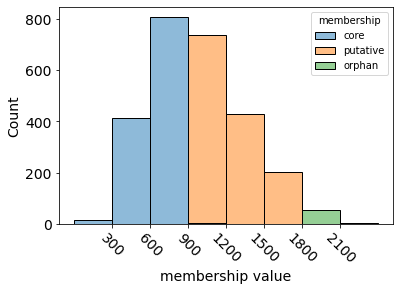

In [43]:
sns.histplot(bgc_summary_agg_df5_hist_df_final, x='membership_value', bins=8, binrange=(0,2400), 
             hue='membership')
plt.xticks([300,600,900,1200,1500,1800,2100], rotation=315)
plt.tick_params(
    axis='both',
    labelsize=14)
#plt.rcParams["figure.figsize"] = (1,10)
plt.ylabel('Count', fontsize=14)
plt.xlabel('membership value', fontsize=14)

# plt.savefig('/Users/vincentn/Documents/Papers_and_Talks/Sponge_paper_2020/Membership_value_histogram.pdf', bbox_inches='tight')


### How often do BGCs cluster with MiBIG BGCs?

In [44]:
bgc_summary_agg_df5_gcf_list = set(bgc_summary_agg_df5['gcf_id'].tolist())
print(len(bgc_summary_agg_df5_gcf_list))

255


In [45]:
print(bgc_summary_agg_df5_gcf_list)

{210945, 230404, 215044, 201734, 203269, 219917, 209948, 202780, 217118, 201254, 201767, 202281, 201260, 227375, 203823, 205363, 209459, 201784, 201785, 227898, 206398, 205888, 206912, 214086, 201798, 202312, 219721, 206931, 202324, 227926, 204375, 202329, 201306, 201821, 203871, 201825, 204385, 204900, 227428, 201830, 207976, 228972, 202356, 227444, 205429, 215672, 219268, 206474, 213131, 202380, 219274, 218763, 206990, 206481, 213140, 205463, 216729, 201727, 227485, 201890, 210083, 204968, 214186, 222378, 216237, 201902, 226990, 204466, 227511, 202424, 210105, 219322, 211129, 216762, 203965, 202430, 201407, 222391, 205510, 202951, 205516, 205005, 204492, 203980, 209104, 230098, 201429, 230102, 201943, 203993, 205532, 219870, 206049, 227558, 230120, 205034, 212204, 215277, 204014, 230125, 200946, 211187, 212212, 210700, 211702, 204020, 209656, 211193, 221946, 200957, 228606, 227086, 201985, 209154, 200963, 228100, 200965, 203015, 211721, 200970, 216842, 201996, 213261, 201998, 203535,

In [46]:
# Fetch all GCFs identified from the T=900 main dataset
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/result/data.db") as con:
    cur = con.cursor()
    bgc_ids, gcf_id, membership_value, rank = tuple(zip(*cur.execute(
        "select bgc_id, gcf_id, membership_value, rank from gcf_membership where gcf_id in (210945, 230404, 215044, 201734, 203269, 219917, 209948, 202780, 217118, 201254, 201767, 202281, 201260, 227375, 203823, 205363, 209459, 201784, 201785, 227898, 206398, 205888, 206912, 214086, 201798, 202312, 219721, 206931, 202324, 227926, 204375, 202329, 201306, 201821, 203871, 201825, 204385, 204900, 227428, 201830, 207976, 228972, 202356, 227444, 205429, 215672, 219268, 206474, 213131, 202380, 219274, 218763, 206990, 206481, 213140, 205463, 216729, 201727, 227485, 201890, 210083, 204968, 214186, 222378, 216237, 201902, 226990, 204466, 227511, 202424, 210105, 219322, 211129, 216762, 203965, 202430, 201407, 222391, 205510, 202951, 205516, 205005, 204492, 203980, 209104, 230098, 201429, 230102, 201943, 203993, 205532, 219870, 206049, 227558, 230120, 205034, 212204, 215277, 204014, 230125, 200946, 211187, 212212, 210700, 211702, 204020, 209656, 211193, 221946, 200957, 228606, 227086, 201985, 209154, 200963, 228100, 200965, 203015, 211721, 200970, 216842, 201996, 213261, 201998, 203535, 201999, 202001, 202000, 202003, 209683, 214805, 227090, 214295, 216848, 202009, 216857, 203545, 203037, 210718, 215329, 219426, 209186, 208164, 213797, 207141, 200999, 205096, 228130, 208163, 212780, 228141, 211246, 210225, 201011, 202549, 215863, 216890, 212283, 201019, 209725, 207169, 217412, 202565, 203591, 206152, 201031, 218961, 206161, 227155, 201041, 226133, 201042, 227153, 208729, 204124, 202078, 205157, 227686, 202087, 227688, 203111, 212840, 212842, 227691, 201069, 205168, 212849, 227186, 201585, 209271, 201592, 221561, 210298, 230266, 202620, 207740, 201080, 205176, 201093, 201606, 201608, 205709, 229263, 230803, 203667, 201624, 216473, 202651, 212381, 204702, 227741, 202144, 201637, 209321, 205226, 229290, 217513, 204207, 225711, 202674, 207795, 230324, 201652, 204214, 204725, 202679, 202162, 202675, 230843, 228278, 200969, 201155, 204228, 230853, 209350, 224708, 230858, 201166, 201682, 210386, 212946, 217048, 202202, 201695, 202208, 208355, 201190, 203752, 202221, 201711, 212979, 230900, 229364, 207867, 227327)"
    ).fetchall()))
    T900_GCFs = pd.DataFrame(
        {
            "gcf_id": gcf_id,
            "membership_value": membership_value,
            "rank": rank,
        },
        index=bgc_ids
    )

In [47]:
print(len(T900_GCFs))
print(len(T900_GCFs[T900_GCFs["rank"] == 0]))

2613936
381649


In [48]:
# Merge with BGC metadata
T900_GCFs_summary = pd.merge(T900_GCFs, bgc_meta, how="left", left_index=True, right_index=True)
print(len(T900_GCFs_summary))
print(len(T900_GCFs_summary[T900_GCFs_summary["fragmented"] == 0]))
# Merge with bgc_taxonomy_full at phylum level
T900_GCFs_summary_taxonomy = pd.merge(T900_GCFs_summary, bgc_taxonomy_full_df[bgc_taxonomy_full_df["level"] == 1], how="left", left_index=True, right_index=True)
print(len(T900_GCFs_summary_taxonomy))
# Should focus on the BGCs with rank 0 since that is the level of attribution
T900_GCFs_summary_taxonomy[T900_GCFs_summary_taxonomy["rank"] == 0].head(10)


2613936
1714840
2613936


,gcf_id,membership_value,rank,genome,name_x,fragmented,length,type,taxon_id,level,name_y
1,200946,778,0,,BGC0001286.1,0,16181,mibig,2.0,1.0,Basidiomycota
3,203667,965,0,,BGC0000686.1,0,16277,mibig,15.0,1.0,Ascomycota
4,201682,350,0,,BGC0001839.1,0,21215,mibig,15.0,1.0,Ascomycota
14,200957,684,0,,BGC0000417.1,0,12076,mibig,9.0,1.0,Actinobacteria
15,201041,287,0,,BGC0000910.1,0,1420,mibig,9.0,1.0,Actinobacteria
17,200946,433,0,,BGC0000487.1,0,12140,mibig,38.0,1.0,Firmicutes
19,200946,1109,0,,BGC0000735.1,0,20418,mibig,57.0,1.0,Proteobacteria
21,200946,566,0,,BGC0000817.1,0,6814,mibig,NaN,NaN,NaN
24,200946,435,0,,BGC0000618.1,0,761,mibig,38.0,1.0,Firmicutes
28,213140,1371,0,,BGC0001510.1,0,14535,mibig,9.0,1.0,Actinobacteria


In [49]:
# Get the unique types per GCF and enumerate those that contain mibig
T900_GCFs_mibig_summary = T900_GCFs_summary_taxonomy.groupby('gcf_id')['type'].unique().reset_index()
T900_GCFs_mibig_true_summary = T900_GCFs_mibig_summary[T900_GCFs_mibig_summary['type'].apply(lambda x: 'mibig' in x) == True]
print(len(T900_GCFs_mibig_true_summary))
T900_GCFs_mibig_true_summary_list = T900_GCFs_mibig_true_summary.gcf_id.tolist()
print(len(T900_GCFs_mibig_true_summary_list))
print(len(bgc_summary_agg_df5[bgc_summary_agg_df5['gcf_id'].isin(T900_GCFs_mibig_true_summary_list) == True]))
T900_GCFs_mibig_false_df = bgc_summary_agg_df5[bgc_summary_agg_df5['gcf_id'].isin(T900_GCFs_mibig_true_summary_list) == False]
print(len(T900_GCFs_mibig_false_df))
T900_GCFs_mibig_false_df['class_source'].value_counts()


138
138
2184
486


terpene                               311
betalactone                            51
T1PKS                                  32
arylpolyene                            23
NRPS-like                              19
bacteriocin                            13
T3PKS                                   7
phosphonate                             5
NRPS                                    4
transAT-PKS-like                        4
terpene-bacteriocin                     3
resorcinol                              2
hserlactone                             2
NRPS-like-transAT-PKS-like              2
bacteriocin-proteusin-TfuA-related      1
terpene-NRPS-like                       1
terpene-phosphonate                     1
bacteriocin-thiopeptide                 1
arylpolyene-resorcinol                  1
NRPS-T1PKS                              1
hglE-KS                                 1
other                                   1
Name: class_source, dtype: int64

In [50]:
len(set(T900_GCFs_mibig_false_df[T900_GCFs_mibig_false_df['class_source'] == 'terpene']['gcf_id'].tolist()))

34

In [51]:
print(len(set(T900_GCFs_mibig_false_df[T900_GCFs_mibig_false_df['class_source'] == 'T1PKS']['gcf_id'].tolist())))
print(set(T900_GCFs_mibig_false_df[T900_GCFs_mibig_false_df['class_source'] == 'T1PKS']['gcf_id'].tolist()))

16
{227428, 209350, 227688, 206152, 229290, 227691, 226990, 229263, 227086, 227153, 229364, 227898, 214295, 227511, 222391, 227741}


In [52]:
len(set(T900_GCFs_mibig_false_df[T900_GCFs_mibig_false_df['class_source'] == 'NRPS-like']['gcf_id'].tolist()))

11

In [53]:
print(len(set(T900_GCFs_mibig_false_df[T900_GCFs_mibig_false_df['class_source'] == 'bacteriocin']['gcf_id'].tolist())))
print(set(T900_GCFs_mibig_false_df[T900_GCFs_mibig_false_df['class_source'] == 'bacteriocin']['gcf_id'].tolist()))

2
{219322, 215863}


In [54]:
T900_GCFs_mibig_false_df[T900_GCFs_mibig_false_df['class_source'] == 'bacteriocin-proteusin-TfuA-related']

,name,genome,fragmented,length,type,gcf_id,membership_value,class_source
133,./bigslice_080920/dataset_Med/Aplysina/c01624_...,./bigslice_080920/dataset_Med/Aplysina,0,36237,as5,230324,1278,bacteriocin-proteusin-TfuA-related


In [55]:
T900_GCFs_mibig_false_df[T900_GCFs_mibig_false_df['class_source'] == 'bacteriocin-thiopeptide']

,name,genome,fragmented,length,type,gcf_id,membership_value,class_source
54,./bigslice_080920/dataset_Med/Aplysina/c00315_...,./bigslice_080920/dataset_Med/Aplysina,1,36118,as5,213261,1621,bacteriocin-thiopeptide


In [56]:
# Summarise product class names for concise figures
# Note that some of the hybrids are hyphenated the other way around
# resolved by sorting list
RiPP_list = ['head_to_tail','lanthipeptide','TfuA-related','lassopeptide','proteusin','LAP',
             'thiopeptide']
RiPP_hybrid_list = ['LAP-lassopeptide','LAP-thiopeptide','LAP-proteusin','TfuA-related-proteusin']
bacteriocin_RiPP_hybrid_list = ['bacteriocin-thiopeptide','LAP-bacteriocin',
                          'bacteriocin-proteusin','bacteriocin-proteusin-TfuA-related',
                               'bacteriocin-lanthipeptide']
PKS_list = ['T2PKS','T3PKS','hglE-KS','transAT-PKS-like','arylpolyene','transAT-PKS','T1PKS',
            'PKS-like','resorcinol',]
PKS_hybrid_list = ['T3PKS-transAT-PKS','arylpolyene-resorcinol','arylpolyene-ladderane',
                  'T1PKS-hglE-KS','PKS-like-T3PKS']
NRPS_list = ['NRPS-like','CDPS']
NRPS_PKS_hybrid_list = ['NRPS-transAT-PKS-like','NRPS-T1PKS','NRPS-like-transAT-PKS-like',
                       'NRPS-like-T1PKS','NRPS-transAT-PKS']
mixed_hybrid_bin = ['terpene-bacteriocin','terpene-NRPS-like','NRPS-like-betalactone',
                'terpene-phosphonate']
other_list = ['betalactone','ectoine','phosphonate','hserlactone','nucleoside',
              'oligosaccharide','siderophore','ladderane']

T900_GCFs_mibig_false_df_tmp = T900_GCFs_mibig_false_df.copy()
T900_GCFs_mibig_false_df_tmp['class_source'] = T900_GCFs_mibig_false_df_tmp['class_source'].replace(RiPP_list,'RiPP')
T900_GCFs_mibig_false_df_tmp['class_source'] = T900_GCFs_mibig_false_df_tmp['class_source'].replace(RiPP_hybrid_list,'RiPP hybrid')
T900_GCFs_mibig_false_df_tmp['class_source'] = T900_GCFs_mibig_false_df_tmp['class_source'].replace(bacteriocin_RiPP_hybrid_list,'bacteriocin-RiPP hybrid')
T900_GCFs_mibig_false_df_tmp['class_source'] = T900_GCFs_mibig_false_df_tmp['class_source'].replace(PKS_list,'PKS')
T900_GCFs_mibig_false_df_tmp['class_source'] = T900_GCFs_mibig_false_df_tmp['class_source'].replace(PKS_hybrid_list,'PKS hybrid')
T900_GCFs_mibig_false_df_tmp['class_source'] = T900_GCFs_mibig_false_df_tmp['class_source'].replace(NRPS_list,'NRPS')
T900_GCFs_mibig_false_df_tmp['class_source'] = T900_GCFs_mibig_false_df_tmp['class_source'].replace(NRPS_PKS_hybrid_list,'NRPS-PKS hybrid')
T900_GCFs_mibig_false_df_tmp['class_source'] = T900_GCFs_mibig_false_df_tmp['class_source'].replace(mixed_hybrid_bin,'mixed hybrid')
T900_GCFs_mibig_false_df_tmp['class_source'] = T900_GCFs_mibig_false_df_tmp['class_source'].replace(other_list,'other')

T900_GCFs_mibig_false_plot_df = T900_GCFs_mibig_false_df_tmp['class_source'].value_counts().reset_index()
T900_GCFs_mibig_false_plot_df = T900_GCFs_mibig_false_plot_df.rename(columns={'index':'class_source', 'class_source':'# BGCs'})
T900_GCFs_mibig_false_plot_df



,class_source,# BGCs
0,terpene,311
1,PKS,69
2,other,59
3,NRPS,23
4,bacteriocin,13
5,mixed hybrid,5
6,NRPS-PKS hybrid,3
7,bacteriocin-RiPP hybrid,2
8,PKS hybrid,1


<AxesSubplot:ylabel='class_source'>

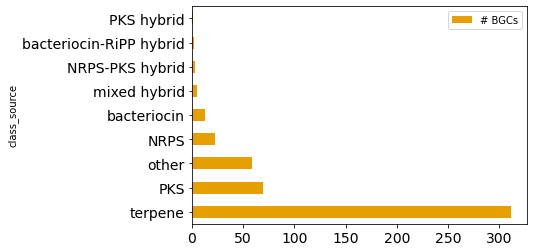

In [57]:
color_dict = {
    'terpene':'#f0e442',
    'PKS':'#e69f00',
    'bacteriocin':'#009e73',
    'NRPS':'#fabdea',
    'other':'#999999',
    'RiPP':'#56b4e9',
    'NRPS-PKS hybrid':'#f81ce5',
    'bacteriocin-RiPP hybrid':'#674ea7',
    'RiPP hybrid':'#0b5394',
    'PKS hybrid':'#fb7403',
    'mixed hybrid':'#783f04',
}

T900_GCFs_mibig_false_plot_df.plot(kind='barh', x='class_source',
            color=['#e69f00','#f0e442','#009e73','#fabdea','#999999','#56b4e9','#f81ce5',
                  '#674ea7','#0b5394','#fb7403','#783f04'], fontsize=14)

## Heatmap of how often BGCs from the same sample are in the same GCF

In [58]:
# Using T=300 query
bgc_summary_agg_df3_copy = bgc_summary_agg_df3.copy()
bgc_summary_agg_df3_copy['genome'] = bgc_summary_agg_df3_copy['genome'].str.split('/', expand=True)[3]
heatmap_300_df = bgc_summary_agg_df3_copy.groupby("gcf_id")["genome"].apply(set).reset_index()
print(len(heatmap_300_df))
heatmap_300_df["combinations"] = heatmap_300_df["genome"].apply(lambda r: list(itertools.combinations(r, 2)))
heatmap_300_df = heatmap_300_df[["gcf_id","combinations"]].explode("combinations")
heatmap_300_df = heatmap_300_df["combinations"].value_counts().to_frame().reset_index().rename(columns={'index':'sample_combinations','combinations':'shared_gcf_count'})
print(len(heatmap_300_df))
print(len(set(heatmap_300_df["sample_combinations"])))
heatmap_300_df["sample_combinations"] = heatmap_300_df["sample_combinations"].apply(lambda x: sorted(list(x))).astype(str)
print(len(heatmap_300_df))
print(len(set(heatmap_300_df["sample_combinations"])))
heatmap_300_df = heatmap_300_df.groupby("sample_combinations")["shared_gcf_count"].sum().to_frame().reset_index()
heatmap_300_df['Sample_A'] =  heatmap_300_df['sample_combinations'].str.split("'", expand=True)[1]
heatmap_300_df['Sample_B'] =  heatmap_300_df['sample_combinations'].str.split("'", expand=True)[3]
heatmap_300_df_pivot_data = pd.pivot_table(heatmap_300_df[["shared_gcf_count","Sample_A","Sample_B"]], values='shared_gcf_count', index='Sample_A', columns='Sample_B')
heatmap_300_df_pivot_data


684
173
173
173
120


Sample_B,7375,Aplysina,CS200,CS202,CS203,CS204,CS211,CS783,MHpat150,MHs1,MHs2,MHs3,MHs5,Petrosia,Sarcotragus
Sample_A,,,,,,,,,,,,,,,
0977,12.0,61.0,57.0,48.0,38.0,41.0,55.0,43.0,15.0,8.0,5.0,6.0,4.0,52.0,30.0
7375,NaN,12.0,10.0,6.0,9.0,6.0,10.0,6.0,5.0,8.0,7.0,6.0,3.0,9.0,6.0
Aplysina,NaN,NaN,79.0,69.0,63.0,62.0,68.0,57.0,15.0,9.0,6.0,8.0,5.0,61.0,42.0
CS200,NaN,NaN,NaN,74.0,64.0,68.0,66.0,65.0,9.0,7.0,5.0,8.0,4.0,64.0,40.0
CS202,NaN,NaN,NaN,NaN,52.0,55.0,54.0,53.0,9.0,4.0,1.0,5.0,2.0,54.0,38.0
CS203,NaN,NaN,NaN,NaN,NaN,71.0,58.0,56.0,10.0,5.0,4.0,7.0,2.0,46.0,33.0
CS204,NaN,NaN,NaN,NaN,NaN,NaN,57.0,56.0,9.0,2.0,2.0,5.0,2.0,48.0,35.0
CS211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0,12.0,5.0,4.0,7.0,5.0,56.0,40.0
CS783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,2.0,2.0,4.0,2.0,55.0,36.0


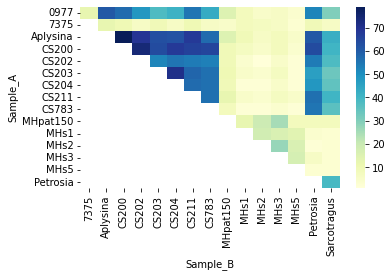

In [59]:
sns.heatmap(heatmap_300_df_pivot_data, cmap="YlGnBu")
plt.subplots_adjust(bottom=0.25, left=0.15)
#plt.savefig("/Users/vincentn/Documents/Papers_and_Talks/Sponge_paper_2020/GCFs_common_to_samples_300_110223.pdf")


In [60]:
# Count the number of GCFs identified from each sample
print(bgc_summary_agg_df3['gcf_id'].nunique())
bgc_summary_agg_df3.groupby('genome')['gcf_id'].nunique()

684


genome
./bigslice_080920/dataset_Med/Aplysina       191
./bigslice_080920/dataset_Med/Petrosia       117
./bigslice_080920/dataset_Med/Sarcotragus     90
./bigslice_080920/dataset_NZ/0977            145
./bigslice_080920/dataset_NZ/7375             81
./bigslice_080920/dataset_NZ/MHpat150         84
./bigslice_080920/dataset_NZ/MHs1             33
./bigslice_080920/dataset_NZ/MHs2             45
./bigslice_080920/dataset_NZ/MHs3             50
./bigslice_080920/dataset_NZ/MHs5             20
./bigslice_080920/dataset_Ton/CS200          173
./bigslice_080920/dataset_Ton/CS202          131
./bigslice_080920/dataset_Ton/CS203          124
./bigslice_080920/dataset_Ton/CS204          118
./bigslice_080920/dataset_Ton/CS211          154
./bigslice_080920/dataset_Ton/CS783          107
Name: gcf_id, dtype: int64

In [61]:
# Using T=900 query
bgc_summary_agg_df5_copy = bgc_summary_agg_df5.copy()
bgc_summary_agg_df5_copy['genome'] = bgc_summary_agg_df5_copy['genome'].str.split('/', expand=True)[3]
heatmap_900_df = bgc_summary_agg_df5_copy.groupby("gcf_id")["genome"].apply(set).reset_index()
print(len(heatmap_900_df))
heatmap_900_df["combinations"] = heatmap_900_df["genome"].apply(lambda r: list(itertools.combinations(r, 2)))
heatmap_900_df = heatmap_900_df[["gcf_id","combinations"]].explode("combinations")
heatmap_900_df = heatmap_900_df["combinations"].value_counts().to_frame().reset_index().rename(columns={'index':'sample_combinations','combinations':'shared_gcf_count'})
print(len(heatmap_900_df))
print(len(set(heatmap_900_df["sample_combinations"])))
heatmap_900_df["sample_combinations"] = heatmap_900_df["sample_combinations"].apply(lambda x: sorted(list(x))).astype(str)
print(len(heatmap_900_df))
print(len(set(heatmap_900_df["sample_combinations"])))
heatmap_900_df = heatmap_900_df.groupby("sample_combinations")["shared_gcf_count"].sum().to_frame().reset_index()
heatmap_900_df['Sample_A'] =  heatmap_900_df['sample_combinations'].str.split("'", expand=True)[1]
heatmap_900_df['Sample_B'] =  heatmap_900_df['sample_combinations'].str.split("'", expand=True)[3]
heatmap_900_df_pivot_data = pd.pivot_table(heatmap_900_df[["shared_gcf_count","Sample_A","Sample_B"]], values='shared_gcf_count', index='Sample_A', columns='Sample_B')
heatmap_900_df_pivot_data


255
163
163
163
120


Sample_B,7375,Aplysina,CS200,CS202,CS203,CS204,CS211,CS783,MHpat150,MHs1,MHs2,MHs3,MHs5,Petrosia,Sarcotragus
Sample_A,,,,,,,,,,,,,,,
0977,12.0,44.0,41.0,36.0,32.0,34.0,39.0,30.0,22.0,10.0,12.0,12.0,8.0,31.0,26.0
7375,NaN,14.0,14.0,10.0,14.0,13.0,14.0,11.0,10.0,7.0,6.0,9.0,5.0,10.0,8.0
Aplysina,NaN,NaN,57.0,47.0,45.0,47.0,45.0,40.0,24.0,14.0,17.0,19.0,11.0,44.0,37.0
CS200,NaN,NaN,NaN,46.0,46.0,48.0,51.0,43.0,22.0,10.0,11.0,13.0,8.0,42.0,34.0
CS202,NaN,NaN,NaN,NaN,36.0,36.0,39.0,34.0,18.0,8.0,10.0,10.0,7.0,34.0,29.0
CS203,NaN,NaN,NaN,NaN,NaN,42.0,34.0,35.0,17.0,10.0,12.0,13.0,8.0,33.0,27.0
CS204,NaN,NaN,NaN,NaN,NaN,NaN,34.0,33.0,18.0,10.0,10.0,13.0,8.0,32.0,26.0
CS211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0,18.0,10.0,10.0,11.0,7.0,34.0,31.0
CS783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,7.0,7.0,10.0,6.0,30.0,27.0


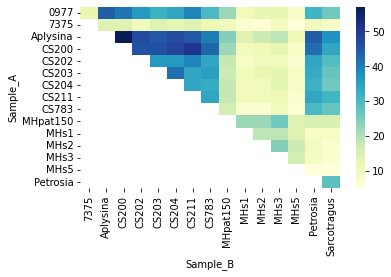

In [62]:
sns.heatmap(heatmap_900_df_pivot_data, cmap="YlGnBu")
plt.subplots_adjust(bottom=0.25, left=0.15)
#plt.savefig("/Users/vincentn/Documents/Papers_and_Talks/Sponge_paper_2020/GCFs_common_to_samples_900_110223.pdf")


In [63]:
# Count the number of GCFs identified from each sample
print(bgc_summary_agg_df5['gcf_id'].nunique())
bgc_summary_agg_df5.groupby('genome')['gcf_id'].nunique()

255


genome
./bigslice_080920/dataset_Med/Aplysina       103
./bigslice_080920/dataset_Med/Petrosia        59
./bigslice_080920/dataset_Med/Sarcotragus     50
./bigslice_080920/dataset_NZ/0977             70
./bigslice_080920/dataset_NZ/7375             50
./bigslice_080920/dataset_NZ/MHpat150         64
./bigslice_080920/dataset_NZ/MHs1             27
./bigslice_080920/dataset_NZ/MHs2             32
./bigslice_080920/dataset_NZ/MHs3             36
./bigslice_080920/dataset_NZ/MHs5             17
./bigslice_080920/dataset_Ton/CS200           84
./bigslice_080920/dataset_Ton/CS202           63
./bigslice_080920/dataset_Ton/CS203           60
./bigslice_080920/dataset_Ton/CS204           61
./bigslice_080920/dataset_Ton/CS211           76
./bigslice_080920/dataset_Ton/CS783           54
Name: gcf_id, dtype: int64

## Inclusion of taxonomy

In [64]:
# Get the GTDB-tk taxonomy
df_list = []
count=0
base_dir = "/Users/vincentn/Documents/Sequencing/BGC_to_bin_mapping_300820/"
matches = ["AplysinaM", "AplysinaP", "Aplysina_BB", "Aplysina_FT", "Aplysina_PK"]

for filename in os.listdir(base_dir):
    if fnmatch.fnmatch(filename, '*final_bin_bgc_df.tsv'):
        if any(x in filename for x in matches):
            continue
        else:
            sname = filename.split("_")[0]
            df = pd.read_csv(os.path.join(base_dir,filename),sep='\t')
            df['sample'] = sname
            print("df for "+ str(sname) + " is " + str(len(df)) + " lines long")
            df_list.append(df)
            
bgc_gtdbtk_tax_df = pd.concat(df_list, axis=0, ignore_index=True)
print("The final bgc_df is " + str(len(bgc_gtdbtk_tax_df)) + " lines long")

df for MHpat150 is 7450 lines long
df for CS204 is 17453 lines long
df for MHs2 is 3455 lines long
df for CS200 is 23923 lines long
df for 7375 is 7869 lines long
df for MHs3 is 5149 lines long
df for Aplysina is 23019 lines long
df for CS211 is 21609 lines long
df for 0977 is 18821 lines long
df for MHs5 is 5522 lines long
df for Petrosia is 19051 lines long
df for CS203 is 20995 lines long
df for MHs1 is 2830 lines long
df for CS202 is 20155 lines long
df for CS783 is 11665 lines long
df for Sarcotragus is 14736 lines long
The final bgc_df is 223702 lines long


In [65]:
# Make a unique identifier (sample+contig_id+region_length) to merge dataframes on
# Note that some contigs were assigned to more than one sample, thus numbers differ
# bgc_gtdbtk_tax_df["unique_id"] = bgc_gtdbtk_tax_df["contig"].str.split("NODE_", expand=True)[1].str.split("_length", expand=True)[0]+"_"+bgc_gtdbtk_tax_df["sample"]
bgc_gtdbtk_tax_df = bgc_gtdbtk_tax_df[bgc_gtdbtk_tax_df['candidate_cluster_length'].isna() == False]
print(len(bgc_gtdbtk_tax_df))
bgc_gtdbtk_tax_df["unique_id"] = bgc_gtdbtk_tax_df["sample"]+bgc_gtdbtk_tax_df["contig"].str.split("NODE_", expand=True)[1].str.split("_length", expand=True)[0]+bgc_gtdbtk_tax_df["candidate_cluster_length"].astype(int).astype(str)
print(len(bgc_gtdbtk_tax_df))
print(len(set(bgc_gtdbtk_tax_df["unique_id"].tolist())))

1937
1937
1928


In [66]:
# Taken from BGC_summary_300820
# List of 8 contigs with BGCs that were attributed to more than one sample
# eight_BGC_duplicates = ['5175_0977', '2930_CS200', '5111_CS200',
#  '6209_CS202', '155_CS211', '1875_MHpat150', '6555_MHpat150', '2262_Petrosia']
eight_BGC_duplicates = ['MHpat150187513523', '0977517513074', 'CS200511114584', 
 'Petrosia226216861', 'CS20262095948', 'CS21115521794', 'MHpat15065557344', 'CS200293022843']

### For T=300 query

In [67]:
# Make a unique identifier (sample+contig_id+region_length) and merge dataframes
# Several BGCs on contig shouldn't matter since contig has one taxonomy
# issues with candidate_cluster_kind in BGC_summary_300820 resolved here too

bgc_summary_agg_df3_copy = bgc_summary_agg_df3.copy()
bgc_summary_agg_df3_copy["unique_id"] = bgc_summary_agg_df3_copy["name"].str.split("/", expand=True)[3]+bgc_summary_agg_df3_copy["name"].str.split("/", expand=True)[4].str.split("_NODE", expand=True)[0].str.split("c", expand=True)[1].astype(int).astype(str)+bgc_summary_agg_df3_copy["length"].astype(str)
print(len(bgc_summary_agg_df3_copy))
print(len(set(bgc_summary_agg_df3_copy["unique_id"].tolist())))
bgc_summary_agg_df3_gtdbtk_tax = pd.merge(bgc_summary_agg_df3_copy, bgc_gtdbtk_tax_df, how="left", on="unique_id")
bgc_summary_agg_df3_gtdbtk_tax


2670
2670


,name,genome,fragmented,length,type,gcf_id,membership_value,class_source,unique_id,Unnamed: 0,...,pplacer_taxonomy,classification_method,note,"other_related_references(genome_id,species_name,radius,ANI,AF)",aa_percent,translation_table,red_value,warnings,class,sample
0,./bigslice_080920/dataset_Med/Aplysina/c00002_...,./bigslice_080920/dataset_Med/Aplysina,0,23291,as5,121150,1012,betalactone,Aplysina223291,5902.0,...,d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,NaN,89.23,11.0,NaN,NaN,c__Dehalococcoidia,Aplysina
1,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,49755,as5,90901,1894,T1PKS,Aplysina349755,18455.0,...,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,NaN,92.36,11.0,NaN,NaN,c__Gemmatimonadetes,Aplysina
2,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,47200,as5,96062,1822,T1PKS,Aplysina347200,18456.0,...,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,NaN,92.36,11.0,NaN,NaN,c__Gemmatimonadetes,Aplysina
3,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,10276,as5,8023,617,bacteriocin,Aplysina310276,18457.0,...,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,taxonomic classification defined by topology a...,topological placement and ANI have congruent s...,NaN,92.36,11.0,NaN,NaN,c__Gemmatimonadetes,Aplysina
4,./bigslice_080920/dataset_Med/Aplysina/c00005_...,./bigslice_080920/dataset_Med/Aplysina,0,13692,as5,42849,1039,bacteriocin,Aplysina513692,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2673,./bigslice_080920/dataset_Ton/CS783/c11027_NOD...,./bigslice_080920/dataset_Ton/CS783,1,5422,as5,5850,924,terpene,CS783110275422,9210.0,...,d__Bacteria;p__Latescibacterota;c__UBA2968;o__...,taxonomic novelty determined using RED,NaN,NaN,85.24,11.0,0.713527,NaN,c__UBA2968,CS783
2674,./bigslice_080920/dataset_Ton/CS783/c11774_NOD...,./bigslice_080920/dataset_Ton/CS783,1,5181,as5,112563,663,betalactone,CS783117745181,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2675,./bigslice_080920/dataset_Ton/CS783/c11779_NOD...,./bigslice_080920/dataset_Ton/CS783,1,5179,as5,2180,166,terpene,CS783117795179,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2676,./bigslice_080920/dataset_Ton/CS783/c11973_NOD...,./bigslice_080920/dataset_Ton/CS783,1,5123,as5,116352,976,T1PKS,CS783119735123,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# Dataframe produces the expected candidate_cluster_kind counts except 6 extra singles?
# This only has an effect if product type is analysed from MAG df! -> stick to class_source
print(len(bgc_summary_agg_df3_gtdbtk_tax[bgc_summary_agg_df3_gtdbtk_tax['unique_id'].isin(eight_BGC_duplicates) == True]))
print(bgc_summary_agg_df3_gtdbtk_tax['candidate_cluster_kind'].value_counts())
bgc_summary_agg_df3_gtdbtk_tax = bgc_summary_agg_df3_gtdbtk_tax[['name', 'genome', 'fragmented', 
                                'length', 'type', 'gcf_id','membership_value', 'class_source',
                                'unique_id','bin', 'contig', 'contig_length','classification',
                                'class', 'sample']]


16
single             1847
neighbouring         25
chemical_hybrid      14
interleaved          12
Name: candidate_cluster_kind, dtype: int64


In [69]:
# Mean membership values by phylum
bgc_summary_agg_df3_gtdbtk_tax['phylum'] = bgc_summary_agg_df3_gtdbtk_tax['classification'].str.split(';', expand=True)[1]
bgc_summary_agg_df3_gtdbtk_tax.groupby("phylum")["membership_value"].mean().sort_values(ascending=False)



/var/folders/4q/44sm58cd3d38vh_kwv88hfdr0000gn/T/ipykernel_3566/646864841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bgc_summary_agg_df3_gtdbtk_tax['phylum'] = bgc_summary_agg_df3_gtdbtk_tax['classification'].str.split(';', expand=True)[1]


phylum
p__Deinococcota          1412.750000
p__Dadabacteria          1327.750000
p__Chloroflexota_B       1284.800000
p__Verrucomicrobiota     1250.647059
p__Latescibacterota      1139.691489
p__Tectomicrobia         1100.272727
p__Spirochaetota         1092.000000
p__Chloroflexota         1091.478947
p__Bacteroidota          1087.511628
p__Crenarchaeota         1064.500000
p__Actinobacteriota      1053.537037
p__UBA8248               1043.000000
p__Bdellovibrionota_B    1042.000000
p__Binatota              1028.454545
p__Gemmatimonadota       1020.538462
p__Poribacteria          1011.421687
p__Acidobacteriota        981.954424
p__Nitrospirota           888.515625
p__Proteobacteria         874.639742
p__Cyanobacteria          602.600000
p__Patescibacteria        442.000000
p__Bdellovibrionota       282.000000
Name: membership_value, dtype: float64

In [70]:
# Note that MAG counts here differ from raw MAG counts since not all have BGCs associated
# Take raw MAG counts identified across all samples
T300_phylum_orphan_BGC_counts = bgc_summary_agg_df3_gtdbtk_tax[bgc_summary_agg_df3_gtdbtk_tax["membership_value"] >= 600]["phylum"].value_counts().to_frame()

phylum_count_dict = {'p__Proteobacteria':162, 'p__Chloroflexota':117, 'p__Acidobacteriota':69,
                     'p__Actinobacteriota':67,'p__Poribacteria':40, 'p__Gemmatimonadota':37,
                     'p__Latescibacterota':32, 'p__Chloroflexota_B':21,'p__Bacteroidota':16,
                     'p__Binatota':15, 'p__Crenarchaeota':13, 'p__Nitrospirota':12,
                     'p__Dadabacteria':11, 'p__Bdellovibrionota':5 , 'p__Verrucomicrobiota':6,
                     'p__Tectomicrobia':5, 'p__Spirochaetota':4, 'p__Cyanobacteria':3,
                     'p__Deinococcota':3, 'p__UBA8248':2, 'p__Bdellovibrionota_B':2,
                     'p__Patescibacteria':1}
phylum_count_df = pd.DataFrame.from_dict(phylum_count_dict, orient='index',
                       columns=['# MAGs'])

T300_phylum_orphan_BGC_by_MAGs_df = pd.merge(phylum_count_df, T300_phylum_orphan_BGC_counts,
                                            left_index=True, right_index=True)
T300_phylum_orphan_BGC_by_MAGs_df = T300_phylum_orphan_BGC_by_MAGs_df.rename(columns={'phylum':'# orphan BGCs'})
T300_phylum_orphan_BGC_by_MAGs_df['# orphan BGCs/MAG'] = (T300_phylum_orphan_BGC_by_MAGs_df['# orphan BGCs']/T300_phylum_orphan_BGC_by_MAGs_df['# MAGs']).round(2)
print(T300_phylum_orphan_BGC_by_MAGs_df['# orphan BGCs'].sum())
T300_phylum_orphan_BGC_by_MAGs_df.sort_values('# orphan BGCs/MAG', ascending=False)


1543


,# MAGs,# orphan BGCs,# orphan BGCs/MAG
p__Verrucomicrobiota,6,34,5.67
p__Acidobacteriota,69,307,4.45
p__Nitrospirota,12,46,3.83
p__Spirochaetota,4,13,3.25
p__Binatota,15,46,3.07
p__Gemmatimonadota,37,113,3.05
p__Proteobacteria,162,432,2.67
p__Latescibacterota,32,83,2.59
p__Bacteroidota,16,40,2.50
p__UBA8248,2,5,2.50


In [71]:
# Membership values by class
bgc_summary_agg_df3_gtdbtk_tax.groupby("class")["membership_value"].mean().sort_values(ascending=False)


class
c__                       1479.161290
c__Deinococci             1412.750000
c__UBA890                 1358.520000
c__UBA1144                1327.750000
c__UBA6911                1327.440000
c__Kiritimatiellae        1288.933333
c__UBA11872               1284.800000
c__Anaerolineae           1281.969697
c__Rhodothermia           1134.242424
c__Entotheonellia         1100.272727
c__Spirochaetia           1092.000000
c__Lentisphaeria          1080.666667
c__Nitrososphaeria        1064.500000
c__Dehalococcoidia        1054.751634
c__Acidimicrobiia         1053.543689
c__Actinobacteria         1053.400000
c__UBA8248                1043.000000
c__Oligoflexia            1042.000000
c__Binatia                1028.454545
c__Gemmatimonadetes       1020.538462
c__Thermoanaerobaculia    1012.900000
c__WGA-4E                 1011.421687
c__Acidobacteriae          991.716981
c__Bacteroidia             976.250000
c__UBA2968                 972.650794
c__Bin61                   929.853659
c__UBA

In [72]:
# Number of orphan BGCs by class
bgc_summary_agg_df3_gtdbtk_tax[bgc_summary_agg_df3_gtdbtk_tax["membership_value"] >= 600]["class"].value_counts()


c__Gammaproteobacteria    266
c__Alphaproteobacteria    166
c__Dehalococcoidia        144
c__Acidobacteriae         137
c__Gemmatimonadetes       113
c__Acidimicrobiia          95
c__WGA-4E                  74
c__Vicinamibacteria        64
c__UBA2968                 53
c__Binatia                 46
c__Nitrospiria             46
c__UBA11872                44
c__Anaerolineae            32
c__Rhodothermia            31
c__Bin61                   31
c__                        30
c__Kiritimatiellae         30
c__Thermoanaerobaculia     27
c__UBA890                  25
c__UBA6911                 23
c__Spirochaetia            13
c__Entotheonellia           9
c__UBA1144                  8
c__Bacteroidia              7
c__UBA8248                  5
c__Actinobacteria           5
c__Deinococci               4
c__Lentisphaeria            3
c__UBA2235                  3
c__Cyanobacteriia           3
c__Nitrososphaeria          2
c__Kapabacteria             2
c__Verrucomicrobiae         1
c__Oligofl

In [73]:
# Number of BGCs not associated with a MAG identified as orphan
print(len(bgc_summary_agg_df3_gtdbtk_tax[(bgc_summary_agg_df3_gtdbtk_tax["bin"].isna() == True)&(bgc_summary_agg_df3_gtdbtk_tax["membership_value"] >= 600)]['membership_value']))
# Overall membership average of BGCs not associated with a MAG
print(bgc_summary_agg_df3_gtdbtk_tax[bgc_summary_agg_df3_gtdbtk_tax["bin"].isna() == True]['membership_value'].mean())


538
793.775641025641


In [74]:
# Number of orphan BGCs by BGC class
T300_BGC_class_count_df = bgc_summary_agg_df3_gtdbtk_tax[bgc_summary_agg_df3_gtdbtk_tax["membership_value"] >= 600]["class_source"].value_counts().to_frame()
T300_BGC_class_count_df = T300_BGC_class_count_df.rename(columns={'class_source':'# orphan BGCs'})
T300_BGC_class_frag_df = bgc_summary_agg_df3_gtdbtk_tax[bgc_summary_agg_df3_gtdbtk_tax["membership_value"] >= 600].groupby("class_source")["fragmented"].mean().round(2).to_frame()
T300_BGC_class_count_final_df = pd.merge(T300_BGC_class_count_df,T300_BGC_class_frag_df,
                                        left_index=True, right_index=True)
T300_BGC_class_count_final_df


,# orphan BGCs,fragmented
terpene,670,0.63
T1PKS,537,0.86
NRPS-like,235,0.74
bacteriocin,146,0.36
betalactone,122,0.52
T3PKS,70,0.83
transAT-PKS-like,53,1.00
arylpolyene,38,0.82
phosphonate,35,0.74
ectoine,20,0.50


In [75]:
# Number of orphan complete BGCs by BGC class
T300_BGC_class_complete_count_df = bgc_summary_agg_df3_gtdbtk_tax[(bgc_summary_agg_df3_gtdbtk_tax["membership_value"] >= 600) & (bgc_summary_agg_df3_gtdbtk_tax["fragmented"] == 0)]["class_source"].value_counts().to_frame()
T300_BGC_class_complete_count_df


,class_source
terpene,245
bacteriocin,93
T1PKS,75
NRPS-like,62
betalactone,59
T3PKS,12
ectoine,10
phosphonate,9
arylpolyene,7
other,7


### For T=900 query

In [76]:
# Merge as above

bgc_summary_agg_df5_copy = bgc_summary_agg_df5.copy()
bgc_summary_agg_df5_copy["unique_id"] = bgc_summary_agg_df5_copy["name"].str.split("/", expand=True)[3]+bgc_summary_agg_df5_copy["name"].str.split("/", expand=True)[4].str.split("_NODE", expand=True)[0].str.split("c", expand=True)[1].astype(int).astype(str)+bgc_summary_agg_df5_copy["length"].astype(str)
print(len(bgc_summary_agg_df5_copy))
print(len(set(bgc_summary_agg_df5_copy["unique_id"].tolist())))
bgc_summary_agg_df5_gtdbtk_tax = pd.merge(bgc_summary_agg_df5_copy, bgc_gtdbtk_tax_df, how="left", on="unique_id")
bgc_summary_agg_df5_gtdbtk_tax = bgc_summary_agg_df5_gtdbtk_tax[['name', 'genome', 'fragmented', 
                                'length', 'type', 'gcf_id','membership_value', 'class_source',
                                'unique_id','bin', 'contig', 'contig_length','classification',
                                'class', 'sample']]

bgc_summary_agg_df5_gtdbtk_tax


2670
2670


,name,genome,fragmented,length,type,gcf_id,membership_value,class_source,unique_id,bin,contig,contig_length,classification,class,sample
0,./bigslice_080920/dataset_Med/Aplysina/c00002_...,./bigslice_080920/dataset_Med/Aplysina,0,23291,as5,230102,1265,betalactone,Aplysina223291,bin.60.fa.metabat2,NODE_2_length_1020925_cov_7.151352,1020925.0,d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...,c__Dehalococcoidia,Aplysina
1,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,49755,as5,201429,1910,T1PKS,Aplysina349755,cluster_DBSCAN_round3758_93,NODE_3_length_682432_cov_37.151215,682432.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina
2,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,47200,as5,201166,1880,T1PKS,Aplysina347200,cluster_DBSCAN_round3758_93,NODE_3_length_682432_cov_37.151215,682432.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina
3,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,10276,as5,200946,731,bacteriocin,Aplysina310276,cluster_DBSCAN_round3758_93,NODE_3_length_682432_cov_37.151215,682432.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina
4,./bigslice_080920/dataset_Med/Aplysina/c00005_...,./bigslice_080920/dataset_Med/Aplysina,0,13692,as5,201821,1126,bacteriocin,Aplysina513692,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2673,./bigslice_080920/dataset_Ton/CS783/c11027_NOD...,./bigslice_080920/dataset_Ton/CS783,1,5422,as5,202221,863,terpene,CS783110275422,bin.15.fa.maxbin2,NODE_11027_length_5422_cov_5.907460,5422.0,d__Bacteria;p__Latescibacterota;c__UBA2968;o__...,c__UBA2968,CS783
2674,./bigslice_080920/dataset_Ton/CS783/c11774_NOD...,./bigslice_080920/dataset_Ton/CS783,1,5181,as5,208355,713,betalactone,CS783117745181,NaN,NaN,NaN,NaN,NaN,NaN
2675,./bigslice_080920/dataset_Ton/CS783/c11779_NOD...,./bigslice_080920/dataset_Ton/CS783,1,5179,as5,215277,228,terpene,CS783117795179,NaN,NaN,NaN,NaN,NaN,NaN
2676,./bigslice_080920/dataset_Ton/CS783/c11973_NOD...,./bigslice_080920/dataset_Ton/CS783,1,5123,as5,227926,1087,T1PKS,CS783119735123,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
# Membership value by phylum
bgc_summary_agg_df5_gtdbtk_tax['phylum'] = bgc_summary_agg_df5_gtdbtk_tax['classification'].str.split(';', expand=True)[1]
bgc_summary_agg_df5_gtdbtk_tax.groupby("phylum")["membership_value"].mean().sort_values(ascending=False)


phylum
p__Deinococcota          1441.750000
p__Dadabacteria          1351.000000
p__Chloroflexota_B       1286.911111
p__Verrucomicrobiota     1238.529412
p__Latescibacterota      1157.297872
p__Spirochaetota         1128.562500
p__Bacteroidota          1114.511628
p__Tectomicrobia         1103.727273
p__Chloroflexota         1101.726316
p__Crenarchaeota         1088.000000
p__UBA8248               1084.222222
p__Bdellovibrionota_B    1074.000000
p__Actinobacteriota      1068.046296
p__Gemmatimonadota       1065.446154
p__Binatota              1058.818182
p__Poribacteria          1031.759036
p__Acidobacteriota       1022.611260
p__Nitrospirota           947.125000
p__Proteobacteria         941.694669
p__Cyanobacteria          720.400000
p__Patescibacteria        490.000000
p__Bdellovibrionota       437.000000
Name: membership_value, dtype: float64

In [78]:
# Note that MAG counts here differ from raw MAG counts since not all have BGCs associated
# Take raw MAG counts identified across all samples
T900_phylum_orphan_BGC_counts = bgc_summary_agg_df5_gtdbtk_tax[bgc_summary_agg_df5_gtdbtk_tax["membership_value"] >= 1800]["phylum"].value_counts().to_frame()

T900_phylum_orphan_BGC_by_MAGs_df = pd.merge(phylum_count_df, T900_phylum_orphan_BGC_counts,
                                            left_index=True, right_index=True)
T900_phylum_orphan_BGC_by_MAGs_df = T900_phylum_orphan_BGC_by_MAGs_df.rename(columns={'phylum':'# orphan BGCs'})
T900_phylum_orphan_BGC_by_MAGs_df['# orphan BGCs/MAG'] = (T900_phylum_orphan_BGC_by_MAGs_df['# orphan BGCs']/T900_phylum_orphan_BGC_by_MAGs_df['# MAGs']).round(2)
print(T900_phylum_orphan_BGC_by_MAGs_df['# orphan BGCs'].sum())
T900_phylum_orphan_BGC_by_MAGs_df.sort_values('# orphan BGCs/MAG', ascending=False)


58


,# MAGs,# orphan BGCs,# orphan BGCs/MAG
p__UBA8248,2,1,0.50
p__Latescibacterota,32,15,0.47
p__Tectomicrobia,5,2,0.40
p__Binatota,15,5,0.33
p__Deinococcota,3,1,0.33
p__Spirochaetota,4,1,0.25
p__Chloroflexota_B,21,4,0.19
p__Gemmatimonadota,37,5,0.14
p__Proteobacteria,162,16,0.10
p__Dadabacteria,11,1,0.09


In [79]:
# Membership values by class
bgc_summary_agg_df5_gtdbtk_tax.groupby("class")["membership_value"].mean().sort_values(ascending=False)


class
c__                       1487.225806
c__Deinococci             1441.750000
c__UBA890                 1353.840000
c__UBA1144                1351.000000
c__UBA6911                1348.120000
c__Anaerolineae           1300.969697
c__UBA11872               1286.911111
c__Kiritimatiellae        1284.966667
c__Rhodothermia           1158.242424
c__Actinobacteria         1143.200000
c__Spirochaetia           1128.562500
c__Entotheonellia         1103.727273
c__Nitrososphaeria        1088.000000
c__UBA8248                1084.222222
c__Oligoflexia            1074.000000
c__Gemmatimonadetes       1065.446154
c__Acidimicrobiia         1064.398058
c__Dehalococcoidia        1062.169935
c__Binatia                1058.818182
c__Thermoanaerobaculia    1032.000000
c__WGA-4E                 1031.759036
c__Acidobacteriae         1028.081761
c__Bacteroidia            1020.625000
c__Bin61                   997.292683
c__UBA2968                 994.952381
c__Lentisphaeria           975.666667
c__Alp

In [80]:
# Number of orphan BGCs by class
bgc_summary_agg_df5_gtdbtk_tax[bgc_summary_agg_df5_gtdbtk_tax["membership_value"] >= 1800]["class"].value_counts()


c__                       10
c__Alphaproteobacteria     8
c__Gammaproteobacteria     8
c__Gemmatimonadetes        5
c__Binatia                 5
c__UBA2968                 5
c__UBA11872                4
c__Acidimicrobiia          2
c__Entotheonellia          2
c__Bin61                   2
c__UBA8248                 1
c__Spirochaetia            1
c__Dehalococcoidia         1
c__Vicinamibacteria        1
c__UBA6911                 1
c__Deinococci              1
c__UBA1144                 1
Name: class, dtype: int64

In [81]:
# Number of BGCs not associated with a MAG identified as orphan
print (len(bgc_summary_agg_df5_gtdbtk_tax[(bgc_summary_agg_df5_gtdbtk_tax["bin"].isna() == True)&(bgc_summary_agg_df5_gtdbtk_tax["membership_value"] >= 1800)]['membership_value']))
# Overall membership average of BGCs not associated with a MAG
print(bgc_summary_agg_df5_gtdbtk_tax[bgc_summary_agg_df5_gtdbtk_tax["bin"].isna() == True]['membership_value'].mean())


1
847.4641025641025


In [82]:
# Number of orphan BGCs by BGC class
T900_BGC_class_count_df = bgc_summary_agg_df5_gtdbtk_tax[bgc_summary_agg_df5_gtdbtk_tax["membership_value"] >= 1800]["class_source"].value_counts().to_frame()
T900_BGC_class_count_df = T900_BGC_class_count_df.rename(columns={'class_source':'# orphan BGCs'})
T900_BGC_class_frag_df = bgc_summary_agg_df5_gtdbtk_tax[bgc_summary_agg_df5_gtdbtk_tax["membership_value"] >= 1800].groupby("class_source")["fragmented"].mean().round(2).to_frame()
T900_BGC_class_count_final_df = pd.merge(T900_BGC_class_count_df,T900_BGC_class_frag_df,
                                        left_index=True, right_index=True)
T900_BGC_class_count_final_df


,# orphan BGCs,fragmented
T1PKS,38,0.26
NRPS-like,7,0.14
NRPS,4,0.25
other,3,0.00
betalactone,2,0.00
phosphonate,2,0.50
terpene-phosphonate,1,0.00
arylpolyene-ladderane,1,1.00
T3PKS,1,1.00


In [83]:
T900_BGC_class_count_final_df_tmp = T900_BGC_class_count_final_df.copy().reset_index()
T900_BGC_class_count_final_df_tmp['index'] = T900_BGC_class_count_final_df_tmp['index'].replace(RiPP_list,'RiPP')
T900_BGC_class_count_final_df_tmp['index'] = T900_BGC_class_count_final_df_tmp['index'].replace(RiPP_hybrid_list,'RiPP hybrid')
T900_BGC_class_count_final_df_tmp['index'] = T900_BGC_class_count_final_df_tmp['index'].replace(bacteriocin_RiPP_hybrid_list,'bacteriocin-RiPP hybrid')
T900_BGC_class_count_final_df_tmp['index'] = T900_BGC_class_count_final_df_tmp['index'].replace(PKS_list,'PKS')
T900_BGC_class_count_final_df_tmp['index'] = T900_BGC_class_count_final_df_tmp['index'].replace(PKS_hybrid_list,'PKS hybrid')
T900_BGC_class_count_final_df_tmp['index'] = T900_BGC_class_count_final_df_tmp['index'].replace(NRPS_list,'NRPS')
T900_BGC_class_count_final_df_tmp['index'] = T900_BGC_class_count_final_df_tmp['index'].replace(NRPS_PKS_hybrid_list,'NRPS-PKS hybrid')
T900_BGC_class_count_final_df_tmp['index'] = T900_BGC_class_count_final_df_tmp['index'].replace(mixed_hybrid_bin,'mixed hybrid')
T900_BGC_class_count_final_df_tmp['index'] = T900_BGC_class_count_final_df_tmp['index'].replace(other_list,'other')

# T900_BGC_class_count_final_plot_df = T900_BGC_class_count_final_df_tmp['index'].value_counts().reset_index()
T900_BGC_class_count_final_df_tmp = T900_BGC_class_count_final_df_tmp.rename(columns={'index':'class_source'})
T900_BGC_class_count_final_df_tmp


,class_source,# orphan BGCs,fragmented
0,PKS,38,0.26
1,NRPS,7,0.14
2,NRPS,4,0.25
3,other,3,0.00
4,other,2,0.00
5,other,2,0.50
6,mixed hybrid,1,0.00
7,PKS hybrid,1,1.00
8,PKS,1,1.00


In [84]:
# Number of orphan complete BGCs by BGC class
T900_BGC_class_complete_count_df = bgc_summary_agg_df5_gtdbtk_tax[(bgc_summary_agg_df5_gtdbtk_tax["membership_value"] >= 1800) & (bgc_summary_agg_df5_gtdbtk_tax["fragmented"] == 0)]["class_source"].value_counts().to_frame()
T900_BGC_class_complete_count_df


,class_source
T1PKS,28
NRPS-like,6
other,3
NRPS,3
betalactone,2
terpene-phosphonate,1
phosphonate,1


In [85]:
# Membership value by MAG
# Make the bin_id used below as well
bgc_summary_agg_df5_gtdbtk_tax_tmp = bgc_summary_agg_df5_gtdbtk_tax.copy()
bgc_summary_agg_df5_gtdbtk_tax_tmp['bin_id'] = bgc_summary_agg_df5_gtdbtk_tax_tmp['name'].str.split('/', expand=True)[3]+'_'+bgc_summary_agg_df5_gtdbtk_tax_tmp['bin']
bgc_summary_agg_df5_gtdbtk_tax_tmp
T900_membership_by_MAG_df = bgc_summary_agg_df5_gtdbtk_tax_tmp.groupby(["bin_id","phylum"])["membership_value"].mean().sort_values(ascending=False).to_frame()
T900_membership_by_MAG_df.head(25)


,,membership_value
bin_id,phylum,
CS202_bin.40.fa.metabat2,p__Latescibacterota,1801.333333
CS211_bin.39.fa.metabat2,p__Chloroflexota,1777.000000
Aplysina_bin.7.fa.metabat2,p__Chloroflexota,1735.000000
Aplysina_bin.98.fa.metabat2,p__Chloroflexota_B,1724.000000
Sarcotragus_bin.10.fa.metabat2,p__Chloroflexota,1717.500000
CS204_bin.58.fa.maxbin2,p__Latescibacterota,1692.500000
CS211_bin.20.fa.metabat2,p__Deinococcota,1690.500000
CS200_bin.12.fa.maxbin2,p__Latescibacterota,1687.666667
CS204_cluster_DBSCAN_round4790_44,p__Chloroflexota,1680.500000


### Merged phylum summary for both cutoffs

In [86]:
summary_phylum_orphan_BGC_by_MAGs_df = pd.merge(T300_phylum_orphan_BGC_by_MAGs_df, 
        T900_phylum_orphan_BGC_by_MAGs_df, left_index=True, right_index=True, how='left')
summary_phylum_orphan_BGC_by_MAGs_df = summary_phylum_orphan_BGC_by_MAGs_df.fillna(0)
summary_phylum_orphan_BGC_by_MAGs_df = summary_phylum_orphan_BGC_by_MAGs_df.drop(columns='# MAGs_y')
summary_phylum_orphan_BGC_by_MAGs_df = summary_phylum_orphan_BGC_by_MAGs_df.rename(
        columns={'# MAGs_x':'# MAGs','# orphan BGCs_x':'# orphan BGCs T=300',
                '# orphan BGCs/MAG_x':'# orphan BGCs/MAG T=300', 
                 '# orphan BGCs_y':'# orphan BGCs T=900',
                '# orphan BGCs/MAG_y':'# orphan BGCs/MAG T=900',})
summary_phylum_orphan_BGC_by_MAGs_df.sort_values('# orphan BGCs/MAG T=300', ascending=False)


,# MAGs,# orphan BGCs T=300,# orphan BGCs/MAG T=300,# orphan BGCs T=900,# orphan BGCs/MAG T=900
p__Verrucomicrobiota,6,34,5.67,0.0,0.00
p__Acidobacteriota,69,307,4.45,4.0,0.06
p__Nitrospirota,12,46,3.83,0.0,0.00
p__Spirochaetota,4,13,3.25,1.0,0.25
p__Binatota,15,46,3.07,5.0,0.33
p__Gemmatimonadota,37,113,3.05,5.0,0.14
p__Proteobacteria,162,432,2.67,16.0,0.10
p__Latescibacterota,32,83,2.59,15.0,0.47
p__Bacteroidota,16,40,2.50,0.0,0.00
p__UBA8248,2,5,2.50,1.0,0.50


In [87]:
# summary_phylum_orphan_BGC_by_MAGs_df.sort_values('# orphan BGCs/MAG T=300', ascending=False).to_csv("/Users/vincentn/Documents/Papers_and_Talks/Sponge_paper_2020/Summary_phylum_orphan_BGC_by_MAGs_df_110223.csv")


## Most different GCFs

### T=300 query

In [88]:
# Number of 'orphan' GCFs
bgc_summary_agg_df3_gtdbtk_tax_gcfs = bgc_summary_agg_df3_gtdbtk_tax.groupby("gcf_id")["membership_value"].mean().sort_values(ascending=False).reset_index()
print(len(bgc_summary_agg_df3_gtdbtk_tax_gcfs[bgc_summary_agg_df3_gtdbtk_tax_gcfs["membership_value"] >= 600]))


570


In [89]:
# 10 most distant GCFs
ten_most_diff_gcfs_overall_list_T300 = bgc_summary_agg_df3_gtdbtk_tax.groupby("gcf_id")["membership_value"].mean().sort_values(ascending=False).head(10).index.tolist()
bgc_summary_agg_df3_gtdbtk_tax[bgc_summary_agg_df3_gtdbtk_tax["gcf_id"].isin(ten_most_diff_gcfs_overall_list_T300)].sort_values("gcf_id")


,name,genome,fragmented,length,type,gcf_id,membership_value,class_source,unique_id,bin,contig,contig_length,classification,class,sample,phylum
1008,./bigslice_080920/dataset_NZ/MHpat150/c00001_N...,./bigslice_080920/dataset_NZ/MHpat150,0,43203,as5,22015,1885,NRPS,MHpat150143203,bin.15.fa.maxbin2,NODE_1_length_2253666_cov_4.554044,2253666.0,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,MHpat150,p__Proteobacteria
1300,./bigslice_080920/dataset_Ton/CS200/c00003_NOD...,./bigslice_080920/dataset_Ton/CS200,0,46306,as5,51322,2097,T1PKS,CS200346306,bin.12.fa.maxbin2,NODE_3_length_1609740_cov_15.383430,1609740.0,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,c__,CS200,p__Latescibacterota
1585,./bigslice_080920/dataset_Ton/CS202/c00006_NOD...,./bigslice_080920/dataset_Ton/CS202,0,46297,as5,51322,2214,T1PKS,CS202646297,bin.40.fa.metabat2,NODE_6_length_344735_cov_8.769579,344735.0,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,c__,CS202,p__Latescibacterota
1860,./bigslice_080920/dataset_Ton/CS203/c01078_NOD...,./bigslice_080920/dataset_Ton/CS203,1,31188,as5,51322,1906,T1PKS,CS203107831188,cluster_DBSCAN_round5_9,NODE_1078_length_45997_cov_6.948964,45997.0,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,c__,CS203,p__Latescibacterota
2039,./bigslice_080920/dataset_Ton/CS204/c00435_NOD...,./bigslice_080920/dataset_Ton/CS204,1,43185,as5,51322,2158,T1PKS,CS20443543185,bin.58.fa.maxbin2,NODE_435_length_66446_cov_2.934272,66446.0,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,c__,CS204,p__Latescibacterota
2514,./bigslice_080920/dataset_Ton/CS783/c00001_NOD...,./bigslice_080920/dataset_Ton/CS783,0,46387,as5,51322,2227,T1PKS,CS783146387,bin.9.fa.metabat2,NODE_1_length_1452608_cov_4.084186,1452608.0,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,c__,CS783,p__Latescibacterota
1305,./bigslice_080920/dataset_Ton/CS200/c00004_NOD...,./bigslice_080920/dataset_Ton/CS200,0,43594,as5,52630,1978,NRPS-like,CS200443594,bin.12.fa.maxbin2,NODE_4_length_1455908_cov_17.544197,1455908.0,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,c__,CS200,p__Latescibacterota
1014,./bigslice_080920/dataset_NZ/MHpat150/c00006_N...,./bigslice_080920/dataset_NZ/MHpat150,0,41941,as5,66380,2082,NRPS-like,MHpat150641941,bin.30.fa.metabat2,NODE_6_length_1195112_cov_1.882971,1195112.0,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,MHpat150,p__Proteobacteria
130,./bigslice_080920/dataset_Med/Aplysina/c01521_...,./bigslice_080920/dataset_Med/Aplysina,1,44590,as5,81444,1921,arylpolyene-ladderane,Aplysina152144590,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,./bigslice_080920/dataset_Med/Aplysina/c00044_...,./bigslice_080920/dataset_Med/Aplysina,0,59426,as5,91905,1957,NRPS,Aplysina4459426,bin.97.fa.metabat2,NODE_44_length_270107_cov_2.833277,270107.0,d__Bacteria;p__Binatota;c__Binatia;o__Bin18;f_...,c__Binatia,Aplysina,p__Binatota


In [90]:
# Most are singletons except 51322 and 91905
# gcf_id 51322 is T1PKS specific to Latescibacterota and Tongan sponges
# gcf_id 91905 is NRPS specific to Binatota and Tongan sponges and Aplysina
print(ten_most_diff_gcfs_overall_list_T300)

[118372, 51322, 99497, 66380, 111374, 52630, 91905, 81444, 119600, 22015]


In [91]:
# Make a list of the two non-singleton GCF BGCs
T300_nonsingleton_BGCs = bgc_summary_agg_df3_gtdbtk_tax[bgc_summary_agg_df3_gtdbtk_tax["gcf_id"].isin([51322, 91905])]['unique_id'].tolist()


### T=900 query

In [92]:
# Number of 'orphan' GCFs
bgc_summary_agg_df5_gtdbtk_tax_gcfs = bgc_summary_agg_df5_gtdbtk_tax.groupby("gcf_id")["membership_value"].mean().sort_values(ascending=False).reset_index()
print(len(bgc_summary_agg_df5_gtdbtk_tax_gcfs[bgc_summary_agg_df5_gtdbtk_tax_gcfs["membership_value"] >= 1800]))


13


In [93]:
# 10 most distant GCFs
ten_most_diff_gcfs_overall_list_T900 = bgc_summary_agg_df5_gtdbtk_tax.groupby("gcf_id")["membership_value"].mean().sort_values(ascending=False).head(10).index.tolist()
bgc_summary_agg_df5_gtdbtk_tax[bgc_summary_agg_df5_gtdbtk_tax["gcf_id"].isin(ten_most_diff_gcfs_overall_list_T900)].sort_values("gcf_id")


,name,genome,fragmented,length,type,gcf_id,membership_value,class_source,unique_id,bin,contig,contig_length,classification,class,sample,phylum
1008,./bigslice_080920/dataset_NZ/MHpat150/c00001_N...,./bigslice_080920/dataset_NZ/MHpat150,0,43203,as5,208729,1883,NRPS,MHpat150143203,bin.15.fa.maxbin2,NODE_1_length_2253666_cov_4.554044,2253666.0,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,MHpat150,p__Proteobacteria
1300,./bigslice_080920/dataset_Ton/CS200/c00003_NOD...,./bigslice_080920/dataset_Ton/CS200,0,46306,as5,209350,2116,T1PKS,CS200346306,bin.12.fa.maxbin2,NODE_3_length_1609740_cov_15.383430,1609740.0,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,c__,CS200,p__Latescibacterota
1585,./bigslice_080920/dataset_Ton/CS202/c00006_NOD...,./bigslice_080920/dataset_Ton/CS202,0,46297,as5,209350,2225,T1PKS,CS202646297,bin.40.fa.metabat2,NODE_6_length_344735_cov_8.769579,344735.0,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,c__,CS202,p__Latescibacterota
1860,./bigslice_080920/dataset_Ton/CS203/c01078_NOD...,./bigslice_080920/dataset_Ton/CS203,1,31188,as5,209350,1914,T1PKS,CS203107831188,cluster_DBSCAN_round5_9,NODE_1078_length_45997_cov_6.948964,45997.0,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,c__,CS203,p__Latescibacterota
2514,./bigslice_080920/dataset_Ton/CS783/c00001_NOD...,./bigslice_080920/dataset_Ton/CS783,0,46387,as5,209350,2244,T1PKS,CS783146387,bin.9.fa.metabat2,NODE_1_length_1452608_cov_4.084186,1452608.0,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,c__,CS783,p__Latescibacterota
15,./bigslice_080920/dataset_Med/Aplysina/c00042_...,./bigslice_080920/dataset_Med/Aplysina,0,41275,as5,214186,1886,other,Aplysina4241275,bin.43.fa.maxbin2,NODE_42_length_272135_cov_1.867291,272135.0,d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...,c__Dehalococcoidia,Aplysina,p__Chloroflexota
563,./bigslice_080920/dataset_Med/Sarcotragus/c000...,./bigslice_080920/dataset_Med/Sarcotragus,0,50275,as5,214295,2097,T1PKS,Sarcotragus3950275,bin.31.fa.metabat2,NODE_39_length_251758_cov_6.715393,251758.0,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,Sarcotragus,p__Proteobacteria
1305,./bigslice_080920/dataset_Ton/CS200/c00004_NOD...,./bigslice_080920/dataset_Ton/CS200,0,43594,as5,216729,1999,NRPS-like,CS200443594,bin.12.fa.maxbin2,NODE_4_length_1455908_cov_17.544197,1455908.0,d__Bacteria;p__Latescibacterota;c__;o__;f__;g_...,c__,CS200,p__Latescibacterota
1296,./bigslice_080920/dataset_Ton/CS200/c00001_NOD...,./bigslice_080920/dataset_Ton/CS200,0,47011,as5,227153,1845,T1PKS,CS200147011,cluster_DBSCAN_round41_0,NODE_1_length_5887685_cov_36.515424,5887685.0,d__Bacteria;p__Latescibacterota;c__UBA2968;o__...,c__UBA2968,CS200,p__Latescibacterota
1850,./bigslice_080920/dataset_Ton/CS203/c00773_NOD...,./bigslice_080920/dataset_Ton/CS203,0,47089,as5,227153,2082,T1PKS,CS20377347089,bin.2.fa.maxbin2,NODE_773_length_57985_cov_20.776522,57985.0,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,c__Vicinamibacteria,CS203,p__Acidobacteriota


In [94]:
# Most are singletons except 209350, 227153, 227511
# gcf_id 209350 is T1PKS specific to Latescibacterota in Tongan sponges (same as above?)
# gcf_id 227153 is T1PKS specific to Latescibacterota and Acidobacteriota in Tongan sponges
# gcf_id 227511 is T1PKS specific to Latescibacterota and Protebacteria in Tongan sponges

print(ten_most_diff_gcfs_overall_list_T900)

[209350, 214295, 229263, 216729, 228130, 227153, 228606, 214186, 208729, 227511]


In [95]:
# Make a list of the two non-singleton GCF BGCs
T900_nonsingleton_BGCs = bgc_summary_agg_df5_gtdbtk_tax[bgc_summary_agg_df5_gtdbtk_tax["gcf_id"].isin([209350, 227153, 227511])]['unique_id'].tolist()


In [96]:
# Compare the two lists
# gcf_id 209350 is T1PKS specific to Latescibacterota in Tongan sponges (same except CS20443543185 not at T=900)
# gcf_id 91905 from T=300 not in T=900 at all
# gcf_id 227153 and 227511 not in T=300 at all
print(len(T300_nonsingleton_BGCs))
print(len(T900_nonsingleton_BGCs))
for i in T300_nonsingleton_BGCs:
    if i not in T900_nonsingleton_BGCs:
        print(i+' not in T900_nonsingleton_BGCs')
for i in T900_nonsingleton_BGCs:
    if i not in T300_nonsingleton_BGCs:
        print(i+' not in T300_nonsingleton_BGCs')

8
8
Aplysina4459426 not in T900_nonsingleton_BGCs
CS2002159512 not in T900_nonsingleton_BGCs
CS20214852381 not in T900_nonsingleton_BGCs
CS20443543185 not in T900_nonsingleton_BGCs
CS200148386 not in T300_nonsingleton_BGCs
CS200147011 not in T300_nonsingleton_BGCs
CS20377347089 not in T300_nonsingleton_BGCs
CS7832350253 not in T300_nonsingleton_BGCs


In [97]:
# Extract the 209350 GCFs from the T=900 main dataset
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/result/data.db") as con:
    cur = con.cursor()
    bgc_ids, gcf_id, membership_value, rank = tuple(zip(*cur.execute(
        "select bgc_id, gcf_id, membership_value, rank from gcf_membership where gcf_id=209350"
    ).fetchall()))
    gcf_209350_membership = pd.DataFrame(
        {
            "gcf_id": gcf_id,
            "membership_value": membership_value,
            "rank": rank,
        },
        index=bgc_ids
    )
    #gcf_membership.to_pickle(bigslice_names)

In [98]:
# Note that on the BiG-SLICE server this is GCF_08405
print(len(gcf_209350_membership))
# Merge with BGC metadata
gcf_209350_summary = pd.merge(gcf_209350_membership, bgc_meta, how="left", left_index=True, right_index=True)
print(len(gcf_209350_summary))
print(len(gcf_209350_summary[gcf_209350_summary["fragmented"] == 0]))
print(len(gcf_209350_summary[gcf_209350_summary["rank"] == 0]))
# Merge with bgc_taxonomy_full at phylum level
gcf_209350_summary_taxonomy = pd.merge(gcf_209350_summary, bgc_taxonomy_full_df[bgc_taxonomy_full_df["level"] == 1], how="left", left_index=True, right_index=True)
print(len(gcf_209350_summary_taxonomy))
# Should focus on the BGCs with rank 0 since that is the level of attribution
gcf_209350_summary_taxonomy[gcf_209350_summary_taxonomy["rank"] == 0]


46
46
28
3
46


,gcf_id,membership_value,rank,genome,name_x,fragmented,length,type,taxon_id,level,name_y
74456,209350,827,0,GCF_004323735.1,GCF_004323735.1/NZ_CP036455.1.region007,0,61533,as5,2689,1,Actinobacteriota
364331,209350,829,0,GCF_009728995.1,GCF_009728995.1/NZ_VTZW01000019.region002,0,52250,as5,2689,1,Actinobacteriota
168966,209350,2216,0,GCF_004349245.1,GCF_004349245.1/NZ_SMLC01000023.region001,1,62709,as5,2689,1,Actinobacteriota


## Relating GCFs to abundant MAGs

In [99]:
# list ten_most_abundant_MAGs_per_sample taken from Sample_vs_abundance_table_131022
ten_most_abundant_MAGs_per_sample = []
with open('/Users/vincentn/Documents/Sequencing/Sponge_paper_sample_vs_abundance_250820/ten_most_abundant_MAGs_per_sample.txt') as f:
    #ten_most_abundant_MAGs_per_sample = f.read()
    for line in f:
        # Remove linebreak which is the last character of the string
        curr_place = line[:-1]
        # Add item to the list
        ten_most_abundant_MAGs_per_sample.append(curr_place)    

print(len(ten_most_abundant_MAGs_per_sample))


160


### T=300 query

In [100]:
# Make the bin_id that in the format of the list
T300_GCF_MAG_overlap = bgc_summary_agg_df3_gtdbtk_tax.copy()
T300_GCF_MAG_overlap['bin_id'] = T300_GCF_MAG_overlap['name'].str.split('/', expand=True)[3]+'_'+T300_GCF_MAG_overlap['bin']
T300_GCF_MAG_overlap = T300_GCF_MAG_overlap[T300_GCF_MAG_overlap['bin_id'].isin(ten_most_abundant_MAGs_per_sample)]
T300_GCF_MAG_overlap


,name,genome,fragmented,length,type,gcf_id,membership_value,class_source,unique_id,bin,contig,contig_length,classification,class,sample,phylum,bin_id
1,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,49755,as5,90901,1894,T1PKS,Aplysina349755,cluster_DBSCAN_round3758_93,NODE_3_length_682432_cov_37.151215,682432.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina,p__Gemmatimonadota,Aplysina_cluster_DBSCAN_round3758_93
2,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,47200,as5,96062,1822,T1PKS,Aplysina347200,cluster_DBSCAN_round3758_93,NODE_3_length_682432_cov_37.151215,682432.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina,p__Gemmatimonadota,Aplysina_cluster_DBSCAN_round3758_93
3,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,10276,as5,8023,617,bacteriocin,Aplysina310276,cluster_DBSCAN_round3758_93,NODE_3_length_682432_cov_37.151215,682432.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina,p__Gemmatimonadota,Aplysina_cluster_DBSCAN_round3758_93
13,./bigslice_080920/dataset_Med/Aplysina/c00035_...,./bigslice_080920/dataset_Med/Aplysina,0,21047,as5,48394,901,terpene,Aplysina3521047,cluster_DBSCAN_round3758_93,NODE_35_length_291383_cov_41.392150,291383.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina,p__Gemmatimonadota,Aplysina_cluster_DBSCAN_round3758_93
14,./bigslice_080920/dataset_Med/Aplysina/c00037_...,./bigslice_080920/dataset_Med/Aplysina,1,48283,as5,90901,1396,T1PKS,Aplysina3748283,bin.56.fa.metabat2,NODE_37_length_285363_cov_3.953368,285363.0,d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...,c__Dehalococcoidia,Aplysina,p__Chloroflexota,Aplysina_bin.56.fa.metabat2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,./bigslice_080920/dataset_Ton/CS783/c00055_NOD...,./bigslice_080920/dataset_Ton/CS783,1,28484,as5,91219,1329,T1PKS,CS7835528484,bin.31.fa.metabat2,NODE_55_length_222845_cov_4.126438,222845.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,CS783,p__Gemmatimonadota,CS783_bin.31.fa.metabat2
2535,./bigslice_080920/dataset_Ton/CS783/c00097_NOD...,./bigslice_080920/dataset_Ton/CS783,0,49501,as5,107301,1813,T1PKS,CS7839749501,bin.31.fa.metabat2,NODE_97_length_169309_cov_3.895669,169309.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,CS783,p__Gemmatimonadota,CS783_bin.31.fa.metabat2
2542,./bigslice_080920/dataset_Ton/CS783/c00209_NOD...,./bigslice_080920/dataset_Ton/CS783,0,27508,as5,43216,1071,betalactone,CS78320927508,bin.31.fa.metabat2,NODE_209_length_112206_cov_3.850079,112206.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,CS783,p__Gemmatimonadota,CS783_bin.31.fa.metabat2
2544,./bigslice_080920/dataset_Ton/CS783/c00230_NOD...,./bigslice_080920/dataset_Ton/CS783,0,23354,as5,34179,1111,terpene,CS78323023354,bin.31.fa.metabat2,NODE_230_length_106564_cov_4.199545,106564.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,CS783,p__Gemmatimonadota,CS783_bin.31.fa.metabat2


In [101]:
# Number of MAGs with overall 'orphan' distance
T300_GCF_MAG_overlap_avg_membership = T300_GCF_MAG_overlap.groupby("bin_id")["membership_value"].mean().sort_values(ascending=False).to_frame()
print(len(T300_GCF_MAG_overlap_avg_membership[T300_GCF_MAG_overlap_avg_membership["membership_value"] >= 600]))


85


### T=900 query

In [102]:
# Make the bin_id that in the format of the list
T900_GCF_MAG_overlap = bgc_summary_agg_df5_gtdbtk_tax.copy()
T900_GCF_MAG_overlap['bin_id'] = T900_GCF_MAG_overlap['name'].str.split('/', expand=True)[3]+'_'+T900_GCF_MAG_overlap['bin']
T900_GCF_MAG_overlap = T900_GCF_MAG_overlap[T900_GCF_MAG_overlap['bin_id'].isin(ten_most_abundant_MAGs_per_sample)]
T900_GCF_MAG_overlap


,name,genome,fragmented,length,type,gcf_id,membership_value,class_source,unique_id,bin,contig,contig_length,classification,class,sample,phylum,bin_id
1,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,49755,as5,201429,1910,T1PKS,Aplysina349755,cluster_DBSCAN_round3758_93,NODE_3_length_682432_cov_37.151215,682432.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina,p__Gemmatimonadota,Aplysina_cluster_DBSCAN_round3758_93
2,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,47200,as5,201166,1880,T1PKS,Aplysina347200,cluster_DBSCAN_round3758_93,NODE_3_length_682432_cov_37.151215,682432.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina,p__Gemmatimonadota,Aplysina_cluster_DBSCAN_round3758_93
3,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,10276,as5,200946,731,bacteriocin,Aplysina310276,cluster_DBSCAN_round3758_93,NODE_3_length_682432_cov_37.151215,682432.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina,p__Gemmatimonadota,Aplysina_cluster_DBSCAN_round3758_93
13,./bigslice_080920/dataset_Med/Aplysina/c00035_...,./bigslice_080920/dataset_Med/Aplysina,0,21047,as5,201682,919,terpene,Aplysina3521047,cluster_DBSCAN_round3758_93,NODE_35_length_291383_cov_41.392150,291383.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina,p__Gemmatimonadota,Aplysina_cluster_DBSCAN_round3758_93
14,./bigslice_080920/dataset_Med/Aplysina/c00037_...,./bigslice_080920/dataset_Med/Aplysina,1,48283,as5,227375,1390,T1PKS,Aplysina3748283,bin.56.fa.metabat2,NODE_37_length_285363_cov_3.953368,285363.0,d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...,c__Dehalococcoidia,Aplysina,p__Chloroflexota,Aplysina_bin.56.fa.metabat2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2534,./bigslice_080920/dataset_Ton/CS783/c00055_NOD...,./bigslice_080920/dataset_Ton/CS783,1,28484,as5,227485,1359,T1PKS,CS7835528484,bin.31.fa.metabat2,NODE_55_length_222845_cov_4.126438,222845.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,CS783,p__Gemmatimonadota,CS783_bin.31.fa.metabat2
2535,./bigslice_080920/dataset_Ton/CS783/c00097_NOD...,./bigslice_080920/dataset_Ton/CS783,0,49501,as5,201429,1820,T1PKS,CS7839749501,bin.31.fa.metabat2,NODE_97_length_169309_cov_3.895669,169309.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,CS783,p__Gemmatimonadota,CS783_bin.31.fa.metabat2
2542,./bigslice_080920/dataset_Ton/CS783/c00209_NOD...,./bigslice_080920/dataset_Ton/CS783,0,27508,as5,213140,1018,betalactone,CS78320927508,bin.31.fa.metabat2,NODE_209_length_112206_cov_3.850079,112206.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,CS783,p__Gemmatimonadota,CS783_bin.31.fa.metabat2
2544,./bigslice_080920/dataset_Ton/CS783/c00230_NOD...,./bigslice_080920/dataset_Ton/CS783,0,23354,as5,212204,1111,terpene,CS78323023354,bin.31.fa.metabat2,NODE_230_length_106564_cov_4.199545,106564.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,CS783,p__Gemmatimonadota,CS783_bin.31.fa.metabat2


In [103]:
# Number of orphan BGCs
print(len(T900_GCF_MAG_overlap[T900_GCF_MAG_overlap["membership_value"] >= 1800]))
T900_GCF_MAG_overlap[T900_GCF_MAG_overlap["membership_value"] >= 1800]

15


,name,genome,fragmented,length,type,gcf_id,membership_value,class_source,unique_id,bin,contig,contig_length,classification,class,sample,phylum,bin_id
1,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,49755,as5,201429,1910,T1PKS,Aplysina349755,cluster_DBSCAN_round3758_93,NODE_3_length_682432_cov_37.151215,682432.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina,p__Gemmatimonadota,Aplysina_cluster_DBSCAN_round3758_93
2,./bigslice_080920/dataset_Med/Aplysina/c00003_...,./bigslice_080920/dataset_Med/Aplysina,0,47200,as5,201166,1880,T1PKS,Aplysina347200,cluster_DBSCAN_round3758_93,NODE_3_length_682432_cov_37.151215,682432.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Aplysina,p__Gemmatimonadota,Aplysina_cluster_DBSCAN_round3758_93
553,./bigslice_080920/dataset_Med/Sarcotragus/c000...,./bigslice_080920/dataset_Med/Sarcotragus,0,68393,as5,201429,1805,T1PKS,Sarcotragus968393,bin.7.fa.maxbin2,NODE_9_length_449693_cov_31.326519,449693.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Sarcotragus,p__Gemmatimonadota,Sarcotragus_bin.7.fa.maxbin2
555,./bigslice_080920/dataset_Med/Sarcotragus/c000...,./bigslice_080920/dataset_Med/Sarcotragus,0,50305,as5,227375,1875,T1PKS,Sarcotragus1250305,bin.40.fa.metabat2,NODE_12_length_433825_cov_36.698848,433825.0,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,Sarcotragus,p__Gemmatimonadota,Sarcotragus_bin.40.fa.metabat2
592,./bigslice_080920/dataset_Med/Sarcotragus/c003...,./bigslice_080920/dataset_Med/Sarcotragus,1,40870,as5,205532,1831,phosphonate,Sarcotragus34640870,cluster_DBSCAN_round6_6,NODE_346_length_75890_cov_8.168974,75890.0,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,Sarcotragus,p__Proteobacteria,Sarcotragus_cluster_DBSCAN_round6_6
690,./bigslice_080920/dataset_NZ/0977/c00001_NODE_...,./bigslice_080920/dataset_NZ/0977,0,50341,as5,201429,1902,T1PKS,0977150341,bin.101.fa.metabat2,NODE_1_length_2060971_cov_78.647566,2060971.0,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,c__Acidimicrobiia,0977,p__Actinobacteriota,0977_bin.101.fa.metabat2
1008,./bigslice_080920/dataset_NZ/MHpat150/c00001_N...,./bigslice_080920/dataset_NZ/MHpat150,0,43203,as5,208729,1883,NRPS,MHpat150143203,bin.15.fa.maxbin2,NODE_1_length_2253666_cov_4.554044,2253666.0,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,MHpat150,p__Proteobacteria,MHpat150_bin.15.fa.maxbin2
1275,./bigslice_080920/dataset_NZ/MHs5/c00036_NODE_...,./bigslice_080920/dataset_NZ/MHs5,0,46279,as5,212946,1934,T1PKS,MHs53646279,bin.2.fa.metabat2,NODE_36_length_90874_cov_3.765535,90874.0,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,MHs5,p__Proteobacteria,MHs5_bin.2.fa.metabat2
1297,./bigslice_080920/dataset_Ton/CS200/c00002_NOD...,./bigslice_080920/dataset_Ton/CS200,0,50218,as5,201429,1916,T1PKS,CS200250218,bin.24.fa.maxbin2,NODE_2_length_2336772_cov_11.565994,2336772.0,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,CS200,p__Proteobacteria,CS200_bin.24.fa.maxbin2
1321,./bigslice_080920/dataset_Ton/CS200/c00038_NOD...,./bigslice_080920/dataset_Ton/CS200,1,45859,as5,227485,1812,T1PKS,CS2003845859,bin.24.fa.metabat2,NODE_38_length_350188_cov_13.555820,350188.0,d__Bacteria;p__Latescibacterota;c__UBA2968;o__...,c__UBA2968,CS200,p__Latescibacterota,CS200_bin.24.fa.metabat2


In [104]:
# Which of these overlap with the most distant GCFs
T900_GCF_MAG_overlap[(T900_GCF_MAG_overlap["membership_value"] >= 1800) & (T900_GCF_MAG_overlap["gcf_id"].isin(ten_most_diff_gcfs_overall_list_T900))]


,name,genome,fragmented,length,type,gcf_id,membership_value,class_source,unique_id,bin,contig,contig_length,classification,class,sample,phylum,bin_id
1008,./bigslice_080920/dataset_NZ/MHpat150/c00001_N...,./bigslice_080920/dataset_NZ/MHpat150,0,43203,as5,208729,1883,NRPS,MHpat150143203,bin.15.fa.maxbin2,NODE_1_length_2253666_cov_4.554044,2253666.0,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,MHpat150,p__Proteobacteria,MHpat150_bin.15.fa.maxbin2
1850,./bigslice_080920/dataset_Ton/CS203/c00773_NOD...,./bigslice_080920/dataset_Ton/CS203,0,47089,as5,227153,2082,T1PKS,CS20377347089,bin.2.fa.maxbin2,NODE_773_length_57985_cov_20.776522,57985.0,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,c__Vicinamibacteria,CS203,p__Acidobacteriota,CS203_bin.2.fa.maxbin2


In [105]:
# Number of MAGs with overall 'orphan' distance
T900_GCF_MAG_overlap_avg_membership = T900_GCF_MAG_overlap.groupby("bin_id")["membership_value"].mean().sort_values(ascending=False).to_frame()
print(len(T900_GCF_MAG_overlap_avg_membership[T900_GCF_MAG_overlap_avg_membership["membership_value"] >= 1800]))


0


In [106]:
T900_GCF_MAG_overlap_avg_membership

,membership_value
bin_id,
CS211_cluster_DBSCAN_round5310_3,1637.000000
CS200_bin.98.fa.metabat2,1619.500000
0977_bin.101.fa.metabat2,1502.000000
Sarcotragus_bin.4.fa.maxbin2,1485.500000
Petrosia_bin.0.fa.maxbin2,1451.500000
...,...
7375_bin.26.fa.metabat2,637.000000
0977_bin.10.fa.metabat2,634.000000
CS202_bin.84.fa.metabat2,571.666667


# Searching for NHLPs and CCC motifs

In [107]:
# Fetch all CCC containing aa_seqs from dataset
# Uses T=300 here -> T=900 has different bgc_ids
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/reports/3/data.db") as con:
    cur = con.cursor()
    id, bgc_id, locus_tag, protein_id, product, aa_seq = tuple(zip(*cur.execute(
        "select id, bgc_id, locus_tag, protein_id, product, aa_seq from cds where aa_seq like '%CCC%'"
    ).fetchall()))
    CCC_cds_table = pd.DataFrame(
        {
            "bgc_id": bgc_id,
            "locus_tag": locus_tag,
            "protein_id": protein_id,
            "product": product,
            "aa_seq": aa_seq,
        },
        index=id
    )

In [108]:
print(len(CCC_cds_table))

166


In [109]:
CCC_cds_table.sort_values('bgc_id').head()

,bgc_id,locus_tag,protein_id,product,aa_seq
62,6,ctg364_43,None,None,MVRQPHKQGGNTMRNGDEMLQQIVEKSALDADFRRQLLADPKSTIS...
616,45,ctg226_12,None,None,MRSGDEMLKQIVDKSALDADFRQQLLADPKSTISQELGITIPDSMN...
644,48,ctg3_867,None,None,MRSGDEMLKQIVEKSSLDADFRQKLIADPKSTICEELDITMPESMS...
652,49,ctg2957_7,None,None,MRSGDEMLQHIVEKSSLDSDFRQQLLADPKTTISEELGITIPESMT...
694,53,ctg129_80,None,None,MNVQSAMQTGEQMQRHLMTKATEDEAFRAQLVADPNATIRQEFDIE...


In [110]:
# Fetch all CCC containing aa_seqs from dataset T=900 as sanity check
# Different bgc_ids from above!
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/reports/5/data.db") as con:
    cur = con.cursor()
    id, bgc_id, locus_tag, protein_id, product, aa_seq = tuple(zip(*cur.execute(
        "select id, bgc_id, locus_tag, protein_id, product, aa_seq from cds where aa_seq like '%CCC%'"
    ).fetchall()))
    CCC_cds_table_900 = pd.DataFrame(
        {
            "bgc_id": bgc_id,
            "locus_tag": locus_tag,
            "protein_id": protein_id,
            "product": product,
            "aa_seq": aa_seq,
        },
        index=id
    )

In [111]:
print(len(CCC_cds_table_900))

166


In [112]:
# Different cds_ids and bgc_ids!!!
# Make sure correct tables are extracted and merged below!!!
CCC_cds_table_900.sort_values('bgc_id').head()

,bgc_id,locus_tag,protein_id,product,aa_seq
304,19,ctg5_232,None,None,MLQHIVEKSALDADFRQQLLADPNATISKELDIAIPESMTIKVHES...
308,19,ctg5_236,None,None,MLSAEDMHRYLTQRAAEDSDFRRGLIADPKGALHQEFGIEIPDHIE...
329,21,ctg177_23,None,None,MRSGDDMLRQIVEKSGLDEDFRQALLTDPKTTISQELGITIPESMS...
363,24,ctg12916_5,None,None,MRSGDEMLQQIVEKSALDADFRQQLLADPKTAISQELGITIPDSMT...
604,39,ctg8651_2,None,None,MQSAEDMRRHLTEKAVENLEFRQQLLADPKSIIQQEFGVTIPDNIN...


In [113]:
# Fetches the cds_id to hmm_id binding
# This is quick
cur = con.cursor()
id, cds_id, hmm_id, bitscore = tuple(zip(*cur.execute(
    "select id, cds_id, hmm_id, bitscore from hsp order by id asc"
).fetchall()))
hsp_table = pd.DataFrame(
    {
        "cds_id": cds_id,
        "hmm_id": hmm_id,
        "bitscore": bitscore,
    },
    index=id
)

In [114]:
print(len(hsp_table))
hsp_table.head()

164631


,cds_id,hmm_id,bitscore
1,2,1166,183.8
2,2,1167,152.3
3,2,592,32.6
4,2,164,25.2
5,3,689,175.8


In [115]:
# No hmm table in reports, need to connect to original paper database
# This is quick
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/result/data.db") as con:
    cur = con.cursor()
    id, accession, name, db_id, model_length = tuple(zip(*cur.execute(
        "select id, accession, name, db_id, model_length from hmm order by id asc"
    ).fetchall()))
    hmm_table = pd.DataFrame(
        {
            "accession": accession,
            "name": name,
            "db_id": db_id,
            "model_length": model_length
        },
        index=id
    )

In [116]:
print(len(hmm_table))
hmm_table.head()

6882


,accession,name,db_id,model_length
1,PF10417.8,1-cysPrx_C,1,40
2,PF00389.29,2-Hacid_dh,1,134
3,PF02826.18,2-Hacid_dh_C,1,178
4,PF00198.22,2-oxoacid_dh,1,233
5,PF04029.13,2-ph_phosp,1,226


In [117]:
# Merge the hmm model table to the hsp table
hmm_hsp_table = pd.merge(hsp_table, hmm_table, how='inner', left_on='hmm_id', right_index=True)


In [118]:
print(len(hmm_hsp_table))
hmm_hsp_table.head()

164631


,cds_id,hmm_id,bitscore,accession,name,db_id,model_length
1,2,1166,183.8,PF07479.13,NAD_Gly3P_dh_C,1,142
377,316,1166,188.7,PF07479.13,NAD_Gly3P_dh_C,1,142
867,733,1166,184.3,PF07479.13,NAD_Gly3P_dh_C,1,142
5023,3851,1166,157.7,PF07479.13,NAD_Gly3P_dh_C,1,142
8548,6202,1166,187.7,PF07479.13,NAD_Gly3P_dh_C,1,142


In [119]:
# Merge with the CCC table
# Note that several hmms with different bitscores are listed
# Also note that length of aa_seq is given in model_length
print(len(set(CCC_cds_table_900.index.tolist())))
print(len(set(CCC_cds_table_900['bgc_id'].tolist())))
# Need to reset index
CCC_cds_table_copy = CCC_cds_table_900.reset_index()
CCC_cds_table_copy = CCC_cds_table_copy.rename(columns={'index':'cds_id'})
# Do the merge
CCC_cds_hmm_hsp_table = pd.merge(CCC_cds_table_copy, hmm_hsp_table, how='left', on='cds_id')
print(len(CCC_cds_hmm_hsp_table))
print(len(set(CCC_cds_hmm_hsp_table['cds_id'].tolist())))
print(len(CCC_cds_hmm_hsp_table.sort_values(['cds_id','bitscore']).drop_duplicates('cds_id')))
# Leave only the highest bit-score
CCC_cds_hmm_hsp_table_final = CCC_cds_hmm_hsp_table.sort_values(['cds_id','bitscore']).drop_duplicates('cds_id')
print(len(set(CCC_cds_hmm_hsp_table_final['bgc_id'].tolist())))
CCC_cds_hmm_hsp_table_final


166
156
712
166
166
156


,cds_id,bgc_id,locus_tag,protein_id,product,aa_seq,hmm_id,bitscore,accession,name,db_id,model_length
0,304,19,ctg5_232,None,None,MLQHIVEKSALDADFRQQLLADPNATISKELDIAIPESMTIKVHES...,1864.0,60.4,AS-TIGR03793,AS-TIGR03793,1.0,77.0
5,308,19,ctg5_236,None,None,MLSAEDMHRYLTQRAAEDSDFRRGLIADPKGALHQEFGIEIPDHIE...,1181.0,29.1,PF02979.15,NHase_alpha,1.0,184.0
9,329,21,ctg177_23,None,None,MRSGDDMLRQIVEKSGLDEDFRQALLTDPKTTISQELGITIPESMS...,1864.0,72.8,AS-TIGR03793,AS-TIGR03793,1.0,77.0
14,363,24,ctg12916_5,None,None,MRSGDEMLQQIVEKSALDADFRQQLLADPKTAISQELGITIPDSMT...,1181.0,29.9,PF02979.15,NHase_alpha,1.0,184.0
19,604,39,ctg8651_2,None,None,MQSAEDMRRHLTEKAVENLEFRQQLLADPKSIIQQEFGVTIPDNIN...,1181.0,31.7,PF02979.15,NHase_alpha,1.0,184.0
...,...,...,...,...,...,...,...,...,...,...,...,...
692,39464,2605,ctg1881_18,None,None,MRAHLTAKAAEDSAFRAQLVADPKGIMNQEFGITVPDNIDIVVHES...,1181.0,32.4,PF02979.15,NHase_alpha,1.0,184.0
697,39535,2610,ctg2957_9,None,None,MRNGDEMLRQIVDKSAVDADFRSQLLADPKGTISAELGVTIPESMT...,1181.0,30.6,PF02979.15,NHase_alpha,1.0,184.0
702,39634,2616,ctg533_20,None,None,MKSAEEMRSNLTEKAAMDLSFRKQLMDDPKGVVQHEFGITVPDNIE...,1181.0,28.2,PF02979.15,NHase_alpha,1.0,184.0
707,39707,2622,ctg4121_1,None,None,MFTSAEEMRRVLTEKASEDSAFRAQLVADPKGVLNQEFGITVPDNI...,1181.0,36.6,PF02979.15,NHase_alpha,1.0,184.0


In [121]:
# Merge with meta data and taxonomy
CCC_meta = pd.merge(CCC_cds_hmm_hsp_table_final, bgc_meta_gcf_5, left_on='bgc_id', right_index=True, how='inner')
CCC_meta = CCC_meta.drop(columns=['protein_id','product','hmm_id','db_id','genome','type','rank'])
CCC_meta_tax_final = pd.merge(CCC_meta, bgc_summary_agg_df5_gtdbtk_tax, left_on='name_y', right_on='name')
CCC_meta_tax_final = CCC_meta_tax_final.drop(columns=['name_y', 'genome', 'fragmented_y', 'length_y', 'sample',
                                                      'type', 'gcf_id_y', 'membership_value_y', 'contig_length'])
CCC_meta_tax_final['sample'] = CCC_meta_tax_final['name'].str.split('/', expand=True)[3]
CCC_meta_tax_final


,cds_id,bgc_id,locus_tag,aa_seq,bitscore,accession,name_x,model_length,fragmented_x,length_x,...,membership_value_x,name,class_source,unique_id,bin,contig,classification,class,phylum,sample
0,304,19,ctg5_232,MLQHIVEKSALDADFRQQLLADPNATISKELDIAIPESMTIKVHES...,60.4,AS-TIGR03793,AS-TIGR03793,77.0,0,13692,...,1126,./bigslice_080920/dataset_Med/Aplysina/c00005_...,bacteriocin,Aplysina513692,NaN,NaN,NaN,NaN,NaN,Aplysina
1,308,19,ctg5_236,MLSAEDMHRYLTQRAAEDSDFRRGLIADPKGALHQEFGIEIPDHIE...,29.1,PF02979.15,NHase_alpha,184.0,0,13692,...,1126,./bigslice_080920/dataset_Med/Aplysina/c00005_...,bacteriocin,Aplysina513692,NaN,NaN,NaN,NaN,NaN,Aplysina
2,329,21,ctg177_23,MRSGDDMLRQIVEKSGLDEDFRQALLTDPKTTISQELGITIPESMS...,72.8,AS-TIGR03793,AS-TIGR03793,77.0,0,10252,...,832,./bigslice_080920/dataset_NZ/0977/c00177_NODE_...,bacteriocin,097717710252,bin.12.fa.maxbin2,NODE_177_length_161780_cov_49.421613,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,p__Proteobacteria,0977
3,363,24,ctg12916_5,MRSGDEMLQQIVEKSALDADFRQQLLADPKTAISQELGITIPDSMT...,29.9,PF02979.15,NHase_alpha,184.0,1,5857,...,649,./bigslice_080920/dataset_Ton/CS211/c12916_NOD...,bacteriocin,CS211129165857,bin.83.fa.metabat2,NODE_12916_length_6919_cov_9.446555,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,p__Proteobacteria,CS211
4,604,39,ctg8651_2,MQSAEDMRRHLTEKAVENLEFRQQLLADPKSIIQQEFGVTIPDNIN...,31.7,PF02979.15,NHase_alpha,184.0,1,5972,...,566,./bigslice_080920/dataset_Ton/CS211/c08651_NOD...,bacteriocin,CS21186515972,NaN,NaN,NaN,NaN,NaN,CS211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,39464,2605,ctg1881_18,MRAHLTAKAAEDSAFRAQLVADPKGIMNQEFGITVPDNIDIVVHES...,32.4,PF02979.15,NHase_alpha,184.0,0,10237,...,897,./bigslice_080920/dataset_Ton/CS202/c01881_NOD...,bacteriocin,CS202188110237,NaN,NaN,NaN,NaN,NaN,CS202
162,39535,2610,ctg2957_9,MRNGDEMLRQIVDKSAVDADFRSQLLADPKGTISAELGVTIPESMT...,30.6,PF02979.15,NHase_alpha,184.0,0,10252,...,1114,./bigslice_080920/dataset_Ton/CS200/c02957_NOD...,bacteriocin,CS200295710252,bin.15.fa.maxbin2,NODE_2957_length_22712_cov_12.586540,d__Bacteria;p__Acidobacteriota;c__Bin61;o__Bin...,c__Bin61,p__Acidobacteriota,CS200
163,39634,2616,ctg533_20,MKSAEEMRSNLTEKAAMDLSFRKQLMDDPKGVVQHEFGITVPDNIE...,28.2,PF02979.15,NHase_alpha,184.0,0,10246,...,844,./bigslice_080920/dataset_Med/Petrosia/c00533_...,bacteriocin,Petrosia53310246,bin.75.fa.metabat2,NODE_533_length_43903_cov_51.304276,d__Bacteria;p__Nitrospirota;c__Nitrospiria;o__...,c__Nitrospiria,p__Nitrospirota,Petrosia
164,39707,2622,ctg4121_1,MFTSAEEMRRVLTEKASEDSAFRAQLVADPKGVLNQEFGITVPDNI...,36.6,PF02979.15,NHase_alpha,184.0,1,5475,...,505,./bigslice_080920/dataset_Med/Petrosia/c04121_...,bacteriocin,Petrosia41215475,bin.23.fa.metabat2,NODE_4121_length_11011_cov_4.185226,d__Bacteria;p__Binatota;c__Binatia;o__UBA9968;...,c__Binatia,p__Binatota,Petrosia


In [122]:
# Investigate the unusual hmms
# print(set(CCC_meta_tax_final['name_x'].tolist()))
# ADH_zinc_N is a zinc-binding dehydrogenase
# AS-PF00881 where PF00881 is a conserved nitroreductase
# CoA_transf_3 is an unusual CoA-transferase and may not even be one
# PF00378.19.aligned_c16 where PF00378 is Enoyl-CoA hydratase/isomerase
# QueF is NADPH-dependent 7-cyano-7-deazaguanine reductase
# AS-PF00561 where PF00561 is Abhydrolase_1
# CobN-Mg_chel is CobN/Magnesium Chelatase
# Rieske are iron–sulfur protein components of some cytochrome complexes

CCC_meta_tax_final_unusuals_df = CCC_meta_tax_final[CCC_meta_tax_final['name_x'].isin(['NHase_alpha','AS-TIGR03793']) == False]
print(len(CCC_meta_tax_final_unusuals_df))
CCC_meta_tax_final_unusuals_df['aa_length'] = CCC_meta_tax_final_unusuals_df['aa_seq'].apply(lambda x: len(x))
# Model for precursor peptide should be less than 200 aa
print(len(CCC_meta_tax_final_unusuals_df[CCC_meta_tax_final_unusuals_df['aa_length'] < 200]))
CCC_meta_tax_final_unusuals_df = CCC_meta_tax_final_unusuals_df[CCC_meta_tax_final_unusuals_df['aa_length'] < 200]
# Eliminate unrelevant BGC classes
# Note that some NaN are lost in this step but seqeunces don't seem to be relevant
relevant_types_list = ['bacteriocin-lanthipeptide', 'lanthipeptide', 'LAP-thiopeptide', 'bacteriocin']
CCC_meta_tax_final_unusuals_df = CCC_meta_tax_final_unusuals_df[CCC_meta_tax_final_unusuals_df['class_source'].isin(relevant_types_list) == True]
display(CCC_meta_tax_final_unusuals_df)

# Last bacteriocin with CCCGW may be relevant?
CCC_meta_tax_final_unusuals_df['aa_seq'].tolist()


35
18


/var/folders/4q/44sm58cd3d38vh_kwv88hfdr0000gn/T/ipykernel_3566/2418336548.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CCC_meta_tax_final_unusuals_df['aa_length'] = CCC_meta_tax_final_unusuals_df['aa_seq'].apply(lambda x: len(x))


,cds_id,bgc_id,locus_tag,aa_seq,bitscore,accession,name_x,model_length,fragmented_x,length_x,...,name,class_source,unique_id,bin,contig,classification,class,phylum,sample,aa_length
13,2968,195,ctg2804_8,VLLALGVPDLALHYAVVTWDLQEFWEAVLREDYETAAGVAPIWGVA...,NaN,NaN,NaN,NaN,1,19864,...,./bigslice_080920/dataset_Ton/CS200/c02804_NOD...,bacteriocin-lanthipeptide,CS200280419864,cluster_DBSCAN_round3774_23,NODE_2804_length_23641_cov_15.383686,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,c__Vicinamibacteria,p__Acidobacteriota,CS200,175
80,17638,1184,ctg1935_6,LKGDRYDGRSEKANATNAVYTPPELNKVVIRELRNLEDECYNRFKP...,NaN,NaN,NaN,NaN,1,20159,...,./bigslice_080920/dataset_Ton/CS200/c01935_NOD...,lanthipeptide,CS200193520159,bin.102.fa.metabat2,NODE_1935_length_31330_cov_3.879787,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,c__Acidobacteriae,p__Acidobacteriota,CS200,79
96,20476,1373,ctg3964_4,MKLTVLARVEDRFDAPGVVISPAGCCCCCCAVGGFAG,NaN,NaN,NaN,NaN,1,16726,...,./bigslice_080920/dataset_NZ/0977/c03964_NODE_...,LAP-thiopeptide,0977396416726,bin.83.fa.metabat2,NODE_3964_length_16726_cov_5.675342,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,c__Vicinamibacteria,p__Acidobacteriota,0977,37
158,38526,2546,ctg430_43,LFAVPIAILPHEVGHYLVLLALGVPDLALHYAVVTWDLQEFWEAVL...,NaN,NaN,NaN,NaN,1,21769,...,./bigslice_080920/dataset_Ton/CS783/c00430_NOD...,bacteriocin-lanthipeptide,CS78343021769,bin.64.fa.metabat2,NODE_430_length_63026_cov_2.237714,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,c__Vicinamibacteria,p__Acidobacteriota,CS783,192
160,38754,2558,ctg10_342,MRIYQVEMLEKESLGPSASFRKVAASRTGLMNLHKIVDIVSQRTIF...,NaN,NaN,NaN,NaN,0,10252,...,./bigslice_080920/dataset_Med/Aplysina/c00010_...,bacteriocin,Aplysina1010252,NaN,NaN,NaN,NaN,NaN,Aplysina,59


['VLLALGVPDLALHYAVVTWDLQEFWEAVLREDYETAAGVAPIWGVALSDAAGPLVTYGLVAACCCGCAYWRAHPLLVAVGYVSQLRIWPGARHVVFEMVGIESSAMYDELRVAVLTGIPVQILVGFALAVLLVTGIWLGRSLPRKRRVAACLSMAAGTAAGVFIYAGHVGPWLLP',
 'LKGDRYDGRSEKANATNAVYTPPELNKVVIRELRNLEDECYNRFKPKFQKVTPGQPDRFERMAGTASVASNSYKCACCC',
 'MKLTVLARVEDRFDAPGVVISPAGCCCCCCAVGGFAG',
 'LFAVPIAILPHEVGHYLVLLALGVPDLALHYAVVTWDLQEFWEAVLREDYETAAGVAPIWGVALSDAAGPLVTYGLVAACCCGCAYWRAHPLLVAVGYVSQLRIWPGARHVVFEMVGIESSAMYDELRVAVLTGIPVQILVGFALAVLLVTGIWLGRSLPRKRRVAACLSMAAGTAAGVFIYAGHVGPWLLP',
 'MRIYQVEMLEKESLGPSASFRKVAASRTGLMNLHKIVDIVSQRTIFSPALTFSLCCCGW']

In [124]:
# What are the lengths of the models/precursor peptides
print(set(CCC_meta_tax_final[CCC_meta_tax_final['name_x'].isin(['NHase_alpha','AS-TIGR03793']) == True]['model_length'].tolist()))
print(len(CCC_meta_tax_final[CCC_meta_tax_final['name_x'] == 'AS-TIGR03793']))
print(len(CCC_meta_tax_final[CCC_meta_tax_final['model_length'] == 77]))
print(len(CCC_meta_tax_final[CCC_meta_tax_final['name_x'] == 'NHase_alpha']))
print(len(CCC_meta_tax_final[CCC_meta_tax_final['model_length'] == 184]))
print()
CCC_meta_tax_final_confirmed_df = CCC_meta_tax_final[CCC_meta_tax_final['name_x'].isin(['NHase_alpha','AS-TIGR03793']) == True]
print(len(set(CCC_meta_tax_final_confirmed_df['bgc_id'].tolist())))
print(CCC_meta_tax_final_confirmed_df.groupby(['bgc_id','sample']).size().reset_index()['sample'].value_counts())
print()
print(CCC_meta_tax_final_confirmed_df['sample'].value_counts())
print()
print(CCC_meta_tax_final_confirmed_df.groupby(['bgc_id','phylum']).size().reset_index()['phylum'].value_counts())



{184.0, 77.0}
28
28
103
103

124
CS211          24
Aplysina       18
CS200          16
Petrosia       16
Sarcotragus    13
0977           11
CS202          10
CS783           9
CS204           4
CS203           3
Name: sample, dtype: int64

CS211          26
Aplysina       19
Petrosia       18
CS200          17
Sarcotragus    13
0977           11
CS202          11
CS783           9
CS204           4
CS203           3
Name: sample, dtype: int64

p__Proteobacteria      37
p__Acidobacteriota     12
p__Gemmatimonadota     12
p__Nitrospirota         4
p__Binatota             3
p__Latescibacterota     2
p__UBA8248              2
p__Chloroflexota_B      1
p__Actinobacteriota     1
Name: phylum, dtype: int64


In [ ]:
# Write aa seq file for NHase_alpha
with open('/Users/vincentn/Documents/Papers_and_Talks/Sponge_paper_2020/CCC_RiPPs_NHase_alpha.txt', 'w') as f:
    for index, row in CCC_meta_tax_final_confirmed_df[CCC_meta_tax_final_confirmed_df['name_x'] == 'NHase_alpha'].iterrows():
        f.write(">"+row['name'].split('/')[3]+"_"+row['name'].split('/')[4]+'\n')
        f.write(row['aa_seq']+'\n') 

In [ ]:
# Write aa seq file for TIGR03793
with open('/Users/vincentn/Documents/Papers_and_Talks/Sponge_paper_2020/CCC_RiPPs_TIGR03793.txt', 'w') as f:
    for index, row in CCC_meta_tax_final_confirmed_df[CCC_meta_tax_final_confirmed_df['name_x'] == 'AS-TIGR03793'].iterrows():
        f.write(">"+row['name'].split('/')[3]+"_"+row['name'].split('/')[4]+'\n')
        f.write(row['aa_seq']+'\n') 


### Expand search and target 'NHase_alpha', 'AS-TIGR03793' and 'YcaO' for extraction

In [125]:
# Make a list of all cds identified as NHase_alpha
print(len(set(hmm_hsp_table[hmm_hsp_table['name'].str.contains('NHase_alpha')]['cds_id'].tolist())))
NHase_alpha_cds_ids = set(hmm_hsp_table[hmm_hsp_table['name'].str.contains('NHase_alpha')]['cds_id'].tolist())


222


In [126]:
# Make the NHase_alpha_cds_df
# can't refer to list in fetch statement but can insert it
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/reports/5/data.db") as con:
    cur = con.cursor()
    id, bgc_id, locus_tag, protein_id, product, aa_seq = tuple(zip(*cur.execute(
        "select id, bgc_id, locus_tag, protein_id, product, aa_seq from cds where id in (20490, 19981, 25616, 30736, 30737, 30738, 30739, 30740, 30744, 15385, 36378, 15387, 8220, 13854, 36898, 38947, 22565, 3622, 39464, 13866, 17972, 17973, 12342, 17974, 17975, 28213, 30774, 37948, 32831, 29248, 20034, 18501, 28231, 10319, 25681, 31314, 7252, 33366, 21080, 604, 5212, 9308, 19040, 609, 19043, 30823, 3688, 15464, 37998, 39535, 38000, 2161, 38001, 38002, 38003, 38004, 1142, 7799, 38006, 3193, 14457, 38008, 636, 38009, 38011, 10883, 16010, 36491, 36494, 36498, 10388, 25241, 4252, 11420, 38045, 17056, 19617, 4258, 28833, 6820, 31395, 34468, 4264, 13994, 14509, 10928, 9907, 28853, 27319, 16056, 19644, 18624, 38595, 38598, 38599, 38600, 6857, 36554, 8907, 31951, 21713, 19154, 39634, 29909, 31960, 31451, 24288, 3299, 5358, 21744, 13558, 7431, 32522, 32523, 6413, 27918, 12559, 32525, 5911, 39707, 28960, 27432, 36140, 15661, 27442, 308, 39733, 18230, 18232, 24380, 1853, 27965, 22847, 24383, 835, 2371, 13123, 13127, 31054, 22865, 17234, 5459, 5460, 11612, 3934, 22367, 5472, 12641, 36702, 4966, 5992, 5993, 363, 3436, 20331, 31596, 10098, 6003, 39796, 4470, 8060, 8061, 8062, 21886, 9604, 9605, 12164, 2441, 16777, 9614, 8591, 31121, 2450, 2451, 31123, 10133, 34197, 28056, 17305, 3482, 18331, 35225, 7069, 27549, 39840, 7073, 39841, 39842, 39843, 39844, 39845, 19371, 1452, 8108, 21931, 13233, 15793, 947, 9653, 1462, 6582, 30649, 27583, 25536, 31681, 30146, 37829, 28617, 24525, 31183, 35794, 35795, 15828, 29148, 13278, 28641, 25577, 39402, 24556, 13807, 14327, 8184)"
    ).fetchall()))
    NHase_alpha_cds_df = pd.DataFrame(
        {
            "bgc_id": bgc_id,
            "locus_tag": locus_tag,
            "protein_id": protein_id,
            "product": product,
            "aa_seq": aa_seq,
        },
        index=id
    )

In [127]:
NHase_alpha_cds_df.head()

,bgc_id,locus_tag,protein_id,product,aa_seq
308,19,ctg5_236,None,None,MLSAEDMHRYLTQRAAEDSDFRRGLIADPKGALHQEFGIEIPDHIE...
363,24,ctg12916_5,None,None,MRSGDEMLQQIVEKSALDADFRQQLLADPKTAISQELGITIPDSMT...
604,39,ctg8651_2,None,None,MQSAEDMRRHLTEKAVENLEFRQQLLADPKSIIQQEFGVTIPDNIN...
609,40,ctg3771_3,None,None,MRSGDQMLQQVVEKSALDAEFRKQLLADPKSTISAELGITIPESMN...
636,43,ctg556_40,None,None,MRSGDEMLEQLVQKSAQDADFRQALLADPKATITEELGITIPDSMT...


In [128]:
print(len(set(hmm_hsp_table[hmm_hsp_table['name'].str.contains('TIGR03793')]['cds_id'].tolist())))
TIGR03793_cds_ids = set(hmm_hsp_table[hmm_hsp_table['name'].str.contains('TIGR03793')]['cds_id'].tolist())


345


In [129]:
# Make the TIGR03793_cds_df
# can't refer to list in fetch statement but can insert it
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/reports/5/data.db") as con:
    cur = con.cursor()
    id, bgc_id, locus_tag, protein_id, product, aa_seq = tuple(zip(*cur.execute(
        "select id, bgc_id, locus_tag, protein_id, product, aa_seq from cds where id in (20490, 30736, 30737, 30738, 30739, 30740, 14357, 14358, 30744, 8220, 14369, 36898, 38947, 22565, 12342, 30774, 10296, 10303, 32831, 18501, 20589, 2161, 2162, 20594, 20598, 20599, 20600, 14457, 20604, 20605, 20606, 10388, 4252, 28833, 4258, 4264, 14509, 28853, 18624, 18629, 2246, 24837, 20746, 6413, 12559, 8470, 28960, 304, 308, 22847, 2371, 2375, 329, 31054, 12641, 20835, 363, 4470, 2441, 16777, 29065, 8591, 31121, 2450, 2451, 31123, 31124, 31125, 31127, 35225, 16803, 6582, 31178, 31183, 473, 29148, 39402, 6644, 12816, 23075, 39464, 29248, 14914, 21070, 21073, 25173, 33366, 21080, 604, 19036, 19040, 609, 19043, 39535, 629, 636, 37504, 25241, 17054, 17055, 17056, 17058, 31395, 6820, 10928, 27319, 6857, 19154, 39634, 31451, 39707, 27432, 27442, 39733, 834, 835, 13123, 13127, 17234, 4966, 31592, 31596, 879, 880, 39796, 39831, 17305, 21403, 2973, 7069, 17309, 21405, 7073, 17313, 27549, 39840, 39841, 39842, 39843, 39844, 39845, 5034, 19371, 13233, 947, 27583, 25536, 27584, 31681, 37829, 35794, 979, 35795, 13278, 25577, 21492, 35834, 25616, 3095, 3096, 3097, 3098, 15385, 39970, 13349, 7220, 7223, 37948, 25681, 7252, 5212, 9308, 15464, 37998, 38000, 38001, 38002, 38003, 17524, 38004, 38006, 38007, 38008, 3193, 9338, 38009, 35964, 38010, 38011, 9344, 31872, 40076, 40078, 11416, 11417, 11418, 11419, 11420, 11421, 38045, 19617, 15528, 19644, 13506, 31951, 21713, 31954, 29909, 31960, 3297, 3299, 5358, 21744, 13558, 1278, 13566, 7431, 7435, 27918, 25893, 36140, 34098, 27965, 25919, 5459, 5460, 23896, 11612, 5472, 3436, 32121, 21886, 9601, 9602, 9603, 9604, 9605, 9614, 34193, 34195, 34196, 34197, 28056, 3482, 19870, 21931, 1452, 13742, 15792, 15793, 9653, 1462, 19895, 30145, 30146, 15828, 13807, 19981, 36378, 13854, 32291, 3622, 13866, 17970, 17971, 17972, 17973, 17974, 17975, 28213, 36406, 7746, 20034, 28231, 3688, 7799, 38520, 16010, 36491, 36498, 34468, 13994, 9907, 38593, 38594, 38595, 38596, 38597, 38598, 38599, 38600, 36554, 24288, 36581, 20220, 20221, 32522, 32523, 32525, 5911, 3864, 16174, 16175, 18230, 18231, 18232, 1852, 1853, 1854, 24380, 24384, 24382, 24383, 24385, 24386, 24387, 3930, 3934, 22367, 36702, 38752, 5992, 5993, 36713, 20331, 10098, 6003, 8060, 8061, 8062, 28540, 12164, 18324, 10133, 26522, 18331, 16284, 8108, 30648, 30649, 28617, 24525, 28641, 24556, 14327)"
    ).fetchall()))
    TIGR03793_cds_df = pd.DataFrame(
        {
            "bgc_id": bgc_id,
            "locus_tag": locus_tag,
            "protein_id": protein_id,
            "product": product,
            "aa_seq": aa_seq,
        },
        index=id
    )

In [130]:
TIGR03793_cds_df.head()

,bgc_id,locus_tag,protein_id,product,aa_seq
304,19,ctg5_232,None,None,MLQHIVEKSALDADFRQQLLADPNATISKELDIAIPESMTIKVHES...
308,19,ctg5_236,None,None,MLSAEDMHRYLTQRAAEDSDFRRGLIADPKGALHQEFGIEIPDHIE...
329,21,ctg177_23,None,None,MRSGDDMLRQIVEKSGLDEDFRQALLTDPKTTISQELGITIPESMS...
363,24,ctg12916_5,None,None,MRSGDEMLQQIVEKSALDADFRQQLLADPKTAISQELGITIPDSMT...
473,30,ctg2026_21,None,None,VRAQQPRPNLEIEGTRGHQTRTGFRVDGQTSSFYFRTADQNRSYYV...


In [131]:
NHase_alpha_bgc_ids = set(NHase_alpha_cds_df['bgc_id'].tolist())
print(len(NHase_alpha_bgc_ids))
TIGR03793_bgc_ids = set(TIGR03793_cds_df['bgc_id'].tolist())
print(len(TIGR03793_bgc_ids))
# Number of BGCs in both lists
print(len(NHase_alpha_bgc_ids | TIGR03793_bgc_ids))
# Number of BGCs in NHase_alpha_bgc_ids but not TIGR03793_bgc_ids
print(len(NHase_alpha_bgc_ids - TIGR03793_bgc_ids))

180
243
253
10


In [132]:
NHase_alpha_TIGR03793_cds_df = pd.concat([NHase_alpha_cds_df, TIGR03793_cds_df], axis=0)
print(NHase_alpha_TIGR03793_cds_df['locus_tag'].nunique())
print(NHase_alpha_TIGR03793_cds_df.index.nunique())
print(len(NHase_alpha_TIGR03793_cds_df.drop_duplicates()))
NHase_alpha_TIGR03793_cds_df = NHase_alpha_TIGR03793_cds_df.drop_duplicates()
NHase_alpha_TIGR03793_cds_df


357
357
357


,bgc_id,locus_tag,protein_id,product,aa_seq
308,19,ctg5_236,None,None,MLSAEDMHRYLTQRAAEDSDFRRGLIADPKGALHQEFGIEIPDHIE...
363,24,ctg12916_5,None,None,MRSGDEMLQQIVEKSALDADFRQQLLADPKTAISQELGITIPDSMT...
604,39,ctg8651_2,None,None,MQSAEDMRRHLTEKAVENLEFRQQLLADPKSIIQQEFGVTIPDNIN...
609,40,ctg3771_3,None,None,MRSGDQMLQQVVEKSALDAEFRKQLLADPKSTISAELGITIPESMN...
636,43,ctg556_40,None,None,MRSGDEMLEQLVQKSAQDADFRQALLADPKATITEELGITIPDSMT...
...,...,...,...,...,...
38752,2558,ctg10_340,None,None,MRSGDDMLQHIVEKSALDPEFRQQLLNDPKSAISKELDISIPDSMN...
39831,2631,ctg1224_26,None,None,LTYTHSMCYIGRRVSGKYFEVTIMRTSAQLREEIMAKSLIDQDFRQ...
39970,2642,ctg245_22,None,None,MTSATDNGKVQELLARSAIDSDFRTALLTDPRAALEQAAGKQIPDN...
40076,2652,ctg761_44,None,None,VSELKAHITNKAIEDGDFRAQLLADPRSAISAELDLSVPEGFTIHV...


In [133]:
# Merge with hmm_hsp and then taxonomy
# Need to reset index
NHase_alpha_TIGR03793_cds_df_copy = NHase_alpha_TIGR03793_cds_df.copy().reset_index()
NHase_alpha_TIGR03793_cds_df_copy = NHase_alpha_TIGR03793_cds_df_copy.rename(columns={'index':'cds_id'})
# Do the merge
NHase_alpha_TIGR03793_cds_hmm_hsp_df = pd.merge(NHase_alpha_TIGR03793_cds_df_copy, hmm_hsp_table, how='left', on='cds_id')
print(len(NHase_alpha_TIGR03793_cds_hmm_hsp_df))
print(len(set(NHase_alpha_TIGR03793_cds_hmm_hsp_df['cds_id'].tolist())))
print(len(NHase_alpha_TIGR03793_cds_hmm_hsp_df.sort_values(['cds_id','bitscore']).drop_duplicates('cds_id')))
# Leave only the highest bit-score
NHase_alpha_TIGR03793_cds_hmm_hsp_df_final = NHase_alpha_TIGR03793_cds_hmm_hsp_df.sort_values(['cds_id','bitscore']).drop_duplicates('cds_id')
# Print number of BGCs in dataframe
print(len(set(NHase_alpha_TIGR03793_cds_hmm_hsp_df_final['bgc_id'].tolist())))
# Merge with meta data and taxonomy
NHase_alpha_TIGR03793_meta = pd.merge(NHase_alpha_TIGR03793_cds_hmm_hsp_df_final, bgc_meta_gcf_5, left_on='bgc_id', right_index=True, how='inner')
NHase_alpha_TIGR03793_meta = NHase_alpha_TIGR03793_meta.drop(columns=['protein_id','product','hmm_id','db_id','genome','type','rank'])
NHase_alpha_TIGR03793_meta_tax_final = pd.merge(NHase_alpha_TIGR03793_meta, bgc_summary_agg_df5_gtdbtk_tax, left_on='name_y', right_on='name')
NHase_alpha_TIGR03793_meta_tax_final = NHase_alpha_TIGR03793_meta_tax_final.drop(columns=['name_y', 'genome', 'fragmented_y', 'length_y', 'sample',
                                                      'type', 'gcf_id_y', 'membership_value_y', 'contig_length'])
NHase_alpha_TIGR03793_meta_tax_final['sample'] = NHase_alpha_TIGR03793_meta_tax_final['name'].str.split('/', expand=True)[3]
NHase_alpha_TIGR03793_meta_tax_final


1610
357
357
253


,cds_id,bgc_id,locus_tag,aa_seq,bitscore,accession,name_x,model_length,fragmented_x,length_x,...,membership_value_x,name,class_source,unique_id,bin,contig,classification,class,phylum,sample
0,304,19,ctg5_232,MLQHIVEKSALDADFRQQLLADPNATISKELDIAIPESMTIKVHES...,60.4,AS-TIGR03793,AS-TIGR03793,77,0,13692,...,1126,./bigslice_080920/dataset_Med/Aplysina/c00005_...,bacteriocin,Aplysina513692,NaN,NaN,NaN,NaN,NaN,Aplysina
1,308,19,ctg5_236,MLSAEDMHRYLTQRAAEDSDFRRGLIADPKGALHQEFGIEIPDHIE...,29.1,PF02979.15,NHase_alpha,184,0,13692,...,1126,./bigslice_080920/dataset_Med/Aplysina/c00005_...,bacteriocin,Aplysina513692,NaN,NaN,NaN,NaN,NaN,Aplysina
2,329,21,ctg177_23,MRSGDDMLRQIVEKSGLDEDFRQALLTDPKTTISQELGITIPESMS...,72.8,AS-TIGR03793,AS-TIGR03793,77,0,10252,...,832,./bigslice_080920/dataset_NZ/0977/c00177_NODE_...,bacteriocin,097717710252,bin.12.fa.maxbin2,NODE_177_length_161780_cov_49.421613,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,p__Proteobacteria,0977
3,363,24,ctg12916_5,MRSGDEMLQQIVEKSALDADFRQQLLADPKTAISQELGITIPDSMT...,29.9,PF02979.15,NHase_alpha,184,1,5857,...,649,./bigslice_080920/dataset_Ton/CS211/c12916_NOD...,bacteriocin,CS211129165857,bin.83.fa.metabat2,NODE_12916_length_6919_cov_9.446555,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,p__Proteobacteria,CS211
4,473,30,ctg2026_21,VRAQQPRPNLEIEGTRGHQTRTGFRVDGQTSSFYFRTADQNRSYYV...,52.2,AS-TIGR03793,AS-TIGR03793,77,1,20871,...,661,./bigslice_080920/dataset_NZ/0977/c02026_NODE_...,bacteriocin-lanthipeptide,0977202620871,bin.83.fa.metabat2,NODE_2026_length_29257_cov_6.062101,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,c__Vicinamibacteria,p__Acidobacteriota,0977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,39844,2632,ctg5879_11,MSANSWEELQTQVIARAAVDESFRAGVVNDPRAAIATELGVSLPAD...,31.9,PF02979.15,NHase_alpha,184,1,11155,...,610,./bigslice_080920/dataset_Ton/CS200/c05879_NOD...,bacteriocin,CS200587911155,cluster_DBSCAN_round3777_6,NODE_5879_length_12888_cov_1.500196,d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...,c__Dehalococcoidia,p__Chloroflexota,CS200
354,39845,2632,ctg5879_12,MSVNSWEELQTQIIARAAVDESFRAGVVNDPRAAIATELGVSLPAD...,30.8,PF02979.15,NHase_alpha,184,1,11155,...,610,./bigslice_080920/dataset_Ton/CS200/c05879_NOD...,bacteriocin,CS200587911155,cluster_DBSCAN_round3777_6,NODE_5879_length_12888_cov_1.500196,d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...,c__Dehalococcoidia,p__Chloroflexota,CS200
355,39970,2642,ctg245_22,MTSATDNGKVQELLARSAIDSDFRTALLTDPRAALEQAAGKQIPDN...,59.1,AS-TIGR03793,AS-TIGR03793,77,0,23153,...,927,./bigslice_080920/dataset_Ton/CS203/c00245_NOD...,bacteriocin-lanthipeptide,CS20324523153,bin.2.fa.maxbin2,NODE_245_length_108059_cov_19.196123,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,c__Vicinamibacteria,p__Acidobacteriota,CS203
356,40076,2652,ctg761_44,VSELKAHITNKAIEDGDFRAQLLADPRSAISAELDLSVPEGFTIHV...,56.8,AS-TIGR03793,AS-TIGR03793,77,0,10805,...,505,./bigslice_080920/dataset_Ton/CS203/c00761_NOD...,bacteriocin,CS20376110805,bin.6.fa.metabat2,NODE_761_length_58759_cov_4.816261,d__Bacteria;p__Actinobacteriota;c__Acidimicrob...,c__Acidimicrobiia,p__Actinobacteriota,CS203


In [134]:
# Higher number due to one BGC being attributed to two bins
NHase_alpha_TIGR03793_meta_tax_final[NHase_alpha_TIGR03793_meta_tax_final.duplicated(subset='cds_id', keep=False) == True]


,cds_id,bgc_id,locus_tag,aa_seq,bitscore,accession,name_x,model_length,fragmented_x,length_x,...,membership_value_x,name,class_source,unique_id,bin,contig,classification,class,phylum,sample
175,19154,1291,ctg5175_2,MPMPDLNEFRIAYGKAVARAWSDAAYKDQLLNDPRATLASAGIDIP...,32.8,PF02979.15,NHase_alpha,184,1,13074,...,719,./bigslice_080920/dataset_NZ/0977/c05175_NODE_...,bacteriocin-LAP,0977517513074,cluster_DBSCAN_round2_5,NODE_5175_length_13074_cov_5.265390,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,p__Proteobacteria,0977
176,19154,1291,ctg5175_2,MPMPDLNEFRIAYGKAVARAWSDAAYKDQLLNDPRATLASAGIDIP...,32.8,PF02979.15,NHase_alpha,184,1,13074,...,719,./bigslice_080920/dataset_NZ/0977/c05175_NODE_...,bacteriocin-LAP,0977517513074,bin.83.fa.metabat2,NODE_5175_length_13074_cov_5.265390,d__Bacteria;p__Acidobacteriota;c__Vicinamibact...,c__Vicinamibacteria,p__Acidobacteriota,0977


In [135]:
# Try to eliminate non-relevant hits
NHase_alpha_TIGR03793_meta_tax_final_tmp = NHase_alpha_TIGR03793_meta_tax_final.copy()
print(NHase_alpha_TIGR03793_meta_tax_final_tmp['class_source'].value_counts())
print()
unrelevant_list = ['T3PKS','NRPS-like','T1PKS']
unrelevant_NHase_alpha_TIGR03793 = NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final['class_source'].isin(unrelevant_list) == True]
# Drop these
NHase_alpha_TIGR03793_meta_tax_final_tmp = NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final_tmp['class_source'].isin(unrelevant_list) == False]
print(len(NHase_alpha_TIGR03793_meta_tax_final_tmp))
# Length of precursor peptide should be less than 200 aa -> found one that is longerNHase_alpha_TIGR03793_meta_tax_final['aa_length'] = NHase_alpha_TIGR03793_meta_tax_final['aa_seq'].apply(lambda x: len(x))
NHase_alpha_TIGR03793_meta_tax_final_tmp['aa_length'] = NHase_alpha_TIGR03793_meta_tax_final_tmp['aa_seq'].apply(lambda x: len(x))
print(len(NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final_tmp['aa_length'] < 200]))
unrelevant_NHase_alpha_TIGR03793 = NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final_tmp['aa_length'] >= 200]
print(len(unrelevant_NHase_alpha_TIGR03793[unrelevant_NHase_alpha_TIGR03793['aa_seq'].str.contains('CCC')]))
one_to_add_df = unrelevant_NHase_alpha_TIGR03793[unrelevant_NHase_alpha_TIGR03793['aa_seq'].str.contains('CCC')]
# Drop these and add the relevant one back
NHase_alpha_TIGR03793_meta_tax_final_tmp = NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final_tmp['aa_length'] < 200]
print(len(NHase_alpha_TIGR03793_meta_tax_final_tmp))
NHase_alpha_TIGR03793_meta_tax_final_tmp = pd.concat([NHase_alpha_TIGR03793_meta_tax_final_tmp, one_to_add_df], axis=0)
# Some of the RiPP classes contain CCC (CCC more indicative than SAG)
non_bacteriocin_df = NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final_tmp['class_source'] != 'bacteriocin']
print(len(non_bacteriocin_df[non_bacteriocin_df['aa_seq'].str.contains('CCC')]))
four_to_add = non_bacteriocin_df[non_bacteriocin_df['aa_seq'].str.contains('CCC')]
NHase_alpha_TIGR03793_meta_tax_final_tmp = NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final_tmp['class_source'] == 'bacteriocin']
NHase_alpha_TIGR03793_meta_tax_final_tmp = pd.concat([NHase_alpha_TIGR03793_meta_tax_final_tmp, four_to_add], axis=0)
NHase_alpha_TIGR03793_meta_tax_final_tmp


bacteriocin                  329
T3PKS                          8
bacteriocin-LAP                7
bacteriocin-lanthipeptide      6
bacteriocin-proteusin          4
bacteriocin-thiopeptide        2
NRPS-like                      1
T1PKS                          1
Name: class_source, dtype: int64

348
338
1
338
4


,cds_id,bgc_id,locus_tag,aa_seq,bitscore,accession,name_x,model_length,fragmented_x,length_x,...,name,class_source,unique_id,bin,contig,classification,class,phylum,sample,aa_length
0,304,19,ctg5_232,MLQHIVEKSALDADFRQQLLADPNATISKELDIAIPESMTIKVHES...,60.4,AS-TIGR03793,AS-TIGR03793,77,0,13692,...,./bigslice_080920/dataset_Med/Aplysina/c00005_...,bacteriocin,Aplysina513692,NaN,NaN,NaN,NaN,NaN,Aplysina,77
1,308,19,ctg5_236,MLSAEDMHRYLTQRAAEDSDFRRGLIADPKGALHQEFGIEIPDHIE...,29.1,PF02979.15,NHase_alpha,184,0,13692,...,./bigslice_080920/dataset_Med/Aplysina/c00005_...,bacteriocin,Aplysina513692,NaN,NaN,NaN,NaN,NaN,Aplysina,84
2,329,21,ctg177_23,MRSGDDMLRQIVEKSGLDEDFRQALLTDPKTTISQELGITIPESMS...,72.8,AS-TIGR03793,AS-TIGR03793,77,0,10252,...,./bigslice_080920/dataset_NZ/0977/c00177_NODE_...,bacteriocin,097717710252,bin.12.fa.maxbin2,NODE_177_length_161780_cov_49.421613,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,p__Proteobacteria,0977,83
3,363,24,ctg12916_5,MRSGDEMLQQIVEKSALDADFRQQLLADPKTAISQELGITIPDSMT...,29.9,PF02979.15,NHase_alpha,184,1,5857,...,./bigslice_080920/dataset_Ton/CS211/c12916_NOD...,bacteriocin,CS211129165857,bin.83.fa.metabat2,NODE_12916_length_6919_cov_9.446555,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,p__Proteobacteria,CS211,83
5,604,39,ctg8651_2,MQSAEDMRRHLTEKAVENLEFRQQLLADPKSIIQQEFGVTIPDNIN...,31.7,PF02979.15,NHase_alpha,184,1,5972,...,./bigslice_080920/dataset_Ton/CS211/c08651_NOD...,bacteriocin,CS21186515972,NaN,NaN,NaN,NaN,NaN,CS211,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,29248,1946,ctg1846_25,MPTSVGDGPHSSKPPVTHEFVRTECERDLPYCLCPLSSISHGTASR...,30.7,PF02979.15,NHase_alpha,184,0,10645,...,./bigslice_080920/dataset_Med/Aplysina/c01846_...,bacteriocin,Aplysina184610645,bin.31.fa.metabat2,NODE_1846_length_42367_cov_0.857741,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,p__Proteobacteria,Aplysina,214
201,21403,1434,ctg3964_5,MNSAIELSARLTERASVDGDFRSRLLSDPKAAVHEELGVEVPDGIA...,64.6,AS-TIGR03793,AS-TIGR03793,77,1,16172,...,./bigslice_080920/dataset_Ton/CS211/c03964_NOD...,bacteriocin-LAP,CS211396416172,NaN,NaN,NaN,NaN,NaN,CS211,83
202,21405,1434,ctg3964_7,MNSAIELSARLTERASVDGDFRSRLLSDPKAAVHEELGVEVPDGIA...,65.4,AS-TIGR03793,AS-TIGR03793,77,1,16172,...,./bigslice_080920/dataset_Ton/CS211/c03964_NOD...,bacteriocin-LAP,CS211396416172,NaN,NaN,NaN,NaN,NaN,CS211,83
205,21744,1456,ctg315_27,MQSAEEMRAHLTSKAAEDPAFRAQLIADPKGVMNQEFGIAVPDTIE...,32.5,PF02979.15,NHase_alpha,184,1,36118,...,./bigslice_080920/dataset_Med/Aplysina/c00315_...,bacteriocin-thiopeptide,Aplysina31536118,cluster_DBSCAN_round4_15,NODE_315_length_122801_cov_10.366785,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,p__Proteobacteria,Aplysina,84


In [136]:
print(NHase_alpha_TIGR03793_meta_tax_final_tmp['class_source'].value_counts())
print()

bacteriocin                321
bacteriocin-LAP              2
bacteriocin-thiopeptide      2
Name: class_source, dtype: int64



In [137]:
# What are the lengths of the models/precursor peptides
print(len(NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final_tmp['name_x'] == 'AS-TIGR03793']))
print(len(NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final_tmp['name_x'] == 'NHase_alpha']))
print(len(NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final_tmp["aa_seq"].str.contains("CCCW")]))
print()
print(NHase_alpha_TIGR03793_meta_tax_final_tmp.groupby(['bgc_id','sample']).size().reset_index()['sample'].value_counts())
print()
print(NHase_alpha_TIGR03793_meta_tax_final_tmp['sample'].value_counts())
print()
print(NHase_alpha_TIGR03793_meta_tax_final_tmp.groupby(['bgc_id','phylum']).size().reset_index()['phylum'].value_counts())


123
199
69

Aplysina       38
CS211          38
CS200          24
Petrosia       23
CS204          22
CS203          19
Sarcotragus    17
0977           16
CS202          15
CS783          13
Name: sample, dtype: int64

Aplysina       66
CS204          53
CS211          40
CS203          40
CS200          38
Petrosia       25
Sarcotragus    18
0977           16
CS202          16
CS783          13
Name: sample, dtype: int64

p__Proteobacteria      53
p__Acidobacteriota     29
p__Gemmatimonadota     14
p__Actinobacteriota    10
p__Nitrospirota         7
p__Chloroflexota        5
p__UBA8248              4
p__Binatota             3
p__Latescibacterota     2
p__Chloroflexota_B      1
Name: phylum, dtype: int64


In [138]:
print(len(NHase_alpha_TIGR03793_meta_tax_final_tmp))
print(len(NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final_tmp['aa_seq'].str.contains('EE|CCC|SAG')]))
NHase_alpha_TIGR03793_meta_tax_final_confirmed = NHase_alpha_TIGR03793_meta_tax_final_tmp[NHase_alpha_TIGR03793_meta_tax_final_tmp['aa_seq'].str.contains('EE|CCC|SAG')]
NHase_alpha_TIGR03793_meta_tax_final_confirmed


325
253


,cds_id,bgc_id,locus_tag,aa_seq,bitscore,accession,name_x,model_length,fragmented_x,length_x,...,name,class_source,unique_id,bin,contig,classification,class,phylum,sample,aa_length
0,304,19,ctg5_232,MLQHIVEKSALDADFRQQLLADPNATISKELDIAIPESMTIKVHES...,60.4,AS-TIGR03793,AS-TIGR03793,77,0,13692,...,./bigslice_080920/dataset_Med/Aplysina/c00005_...,bacteriocin,Aplysina513692,NaN,NaN,NaN,NaN,NaN,Aplysina,77
1,308,19,ctg5_236,MLSAEDMHRYLTQRAAEDSDFRRGLIADPKGALHQEFGIEIPDHIE...,29.1,PF02979.15,NHase_alpha,184,0,13692,...,./bigslice_080920/dataset_Med/Aplysina/c00005_...,bacteriocin,Aplysina513692,NaN,NaN,NaN,NaN,NaN,Aplysina,84
2,329,21,ctg177_23,MRSGDDMLRQIVEKSGLDEDFRQALLTDPKTTISQELGITIPESMS...,72.8,AS-TIGR03793,AS-TIGR03793,77,0,10252,...,./bigslice_080920/dataset_NZ/0977/c00177_NODE_...,bacteriocin,097717710252,bin.12.fa.maxbin2,NODE_177_length_161780_cov_49.421613,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,p__Proteobacteria,0977,83
3,363,24,ctg12916_5,MRSGDEMLQQIVEKSALDADFRQQLLADPKTAISQELGITIPDSMT...,29.9,PF02979.15,NHase_alpha,184,1,5857,...,./bigslice_080920/dataset_Ton/CS211/c12916_NOD...,bacteriocin,CS211129165857,bin.83.fa.metabat2,NODE_12916_length_6919_cov_9.446555,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,p__Proteobacteria,CS211,83
5,604,39,ctg8651_2,MQSAEDMRRHLTEKAVENLEFRQQLLADPKSIIQQEFGVTIPDNIN...,31.7,PF02979.15,NHase_alpha,184,1,5972,...,./bigslice_080920/dataset_Ton/CS211/c08651_NOD...,bacteriocin,CS21186515972,NaN,NaN,NaN,NaN,NaN,CS211,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,29248,1946,ctg1846_25,MPTSVGDGPHSSKPPVTHEFVRTECERDLPYCLCPLSSISHGTASR...,30.7,PF02979.15,NHase_alpha,184,0,10645,...,./bigslice_080920/dataset_Med/Aplysina/c01846_...,bacteriocin,Aplysina184610645,bin.31.fa.metabat2,NODE_1846_length_42367_cov_0.857741,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,p__Proteobacteria,Aplysina,214
201,21403,1434,ctg3964_5,MNSAIELSARLTERASVDGDFRSRLLSDPKAAVHEELGVEVPDGIA...,64.6,AS-TIGR03793,AS-TIGR03793,77,1,16172,...,./bigslice_080920/dataset_Ton/CS211/c03964_NOD...,bacteriocin-LAP,CS211396416172,NaN,NaN,NaN,NaN,NaN,CS211,83
202,21405,1434,ctg3964_7,MNSAIELSARLTERASVDGDFRSRLLSDPKAAVHEELGVEVPDGIA...,65.4,AS-TIGR03793,AS-TIGR03793,77,1,16172,...,./bigslice_080920/dataset_Ton/CS211/c03964_NOD...,bacteriocin-LAP,CS211396416172,NaN,NaN,NaN,NaN,NaN,CS211,83
205,21744,1456,ctg315_27,MQSAEEMRAHLTSKAAEDPAFRAQLIADPKGVMNQEFGIAVPDTIE...,32.5,PF02979.15,NHase_alpha,184,1,36118,...,./bigslice_080920/dataset_Med/Aplysina/c00315_...,bacteriocin-thiopeptide,Aplysina31536118,cluster_DBSCAN_round4_15,NODE_315_length_122801_cov_10.366785,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,c__Alphaproteobacteria,p__Proteobacteria,Aplysina,84


In [ ]:
# Write aa seq file for expanded search
with open('/Users/vincentn/Documents/Papers_and_Talks/Sponge_paper_2020/CCC_RiPPs_expanded_search.txt', 'w') as f:
    for index, row in NHase_alpha_TIGR03793_meta_tax_final_confirmed.iterrows():
        f.write(">"+row['name'].split('/')[3]+"_"+row['name'].split('/')[4]+'\n')
        f.write(row['aa_seq']+'\n') 


### Sequences manually curated in Geneious

In [139]:
# Scan in the manually curated dataset and check for overlap with CCC dataframe
# Only works since fasta is one line ID, one line seq
manually_curated_dict = {}
line_count = 0
with open('/Users/vincentn/Documents/Papers_and_Talks/Sponge_paper_2020/CCC_RiPPs_expanded_search_alignment_final_realignmnt_extraction.fasta') as f:
    for line in f:
        line_count += 1
        # Remove linebreak which is the last character of the string
        curr_place = line[:-1]
        # Checks if item is even
        if (line_count % 2) == 0:
            value = curr_place
            manually_curated_dict[key]=value
        else:
            key = curr_place[1:]
            
#manually_curated_dict


In [140]:
# Turn dict into dataframe
manually_curated_df = pd.DataFrame.from_dict(manually_curated_dict, orient='index', 
                                             columns=['aa_seq'])

In [141]:
# Verify that the manually curated dataset at the minimum contains all CCC RiPPs
manually_curated_aa_seq_list = set(manually_curated_df['aa_seq'].tolist())
CCC_meta_tax_final_confirmed_aa_seq_list = set(CCC_meta_tax_final_confirmed_df['aa_seq'].tolist())
print(len(manually_curated_aa_seq_list))
print(len(CCC_meta_tax_final_confirmed_aa_seq_list))
print(len(manually_curated_aa_seq_list|CCC_meta_tax_final_confirmed_aa_seq_list))
print(len(CCC_meta_tax_final_confirmed_aa_seq_list - manually_curated_aa_seq_list))
missing_from_CCC_meta_tax_final_confirmed_df = manually_curated_df[manually_curated_df['aa_seq'].isin(CCC_meta_tax_final_confirmed_aa_seq_list) == False]
missing_from_CCC_meta_tax_final_confirmed_df

133
124
133
0


,aa_seq
Sarcotragus_c03063_NODE_30...region001,MHTSAKEMHDILLQKAVEDADFRADLLADPKGVVNREFGVEVPDSI...
Sarcotragus_c01596_NODE_15...region001,MHGIHRITLGFTPNQSGDETMQSAIDTAMQSAEDMRRQLTEKALVD...
0977_c09373_NODE_93...region001,MRNGPEMISHIIEKSSLDTEFKQRLLADPKDTISGELGINIPDSMT...
Petrosia_c00500_NODE_50...region001,LRSVLQMFIPTTLRTFCVRRPKEEIMNPLAQTAMTAAEDMRRQLTA...
Sarcotragus_c00001_NODE_1_...region002,MDTLVQAALQTANDMQAQLIARASEDDGFRAQLVADPNTAISQEFG...
Sarcotragus_c02525_NODE_25...region001,MQTAEEMRAHLTSKAAEDADFRQQLIADPKGVISQELGITIPDSME...
CS200_c09452_NODE_94...region001,MRSGDEMLQQIVEKSALDEEFRQALLADPKTTICDELGITMPESMT...
CS783_c09644_NODE_96...region001,MKSGDEMLQHLVEKCAMEPDFRQQLLSDPKATISEELGVAIPESMT...
CS211_c00696_NODE_69...region001,MKSGDEMLQHLVEKCAMEPDFRQQLLSDPKATISEELGVAIPESMT...
Sarcotragus_c00387_NODE_38...region001,MKTAPEMLSHLAERSVTDMDFRAQLLSNPKGVMHEEFGITIPDSMD...


In [142]:
# Make dataframe for manually curated dataset and map out BGC counts per sampe and taxonomy
print(missing_from_CCC_meta_tax_final_confirmed_df['aa_seq'].tolist())

['MHTSAKEMHDILLQKAVEDADFRADLLADPKGVVNREFGVEVPDSINIKVHESDMSTVHLALPPQEQLSEEQLRAISAGLSCCG', 'MHGIHRITLGFTPNQSGDETMQSAIDTAMQSAEDMRRQLTEKALVDEDFRRQLVADPKGAIHQEFGLVVPENMEIRVHESTNSEFHLALPANGGDLSEEQLEAIAAGLSCCL', 'MRNGPEMISHIIEKSSLDTEFKQRLLADPKDTISGELGINIPDSMTIKVHESDLETIHLALPPGPNITEEQLEAVSAGLSCCL', 'LRSVLQMFIPTTLRTFCVRRPKEEIMNPLAQTAMTAAEDMRRQLTAKAVEDMEFRQQLVADPKAVIEQEFGISVPDDLNVQVHESSEETLHLALPATPELSEKQLDQIAAGLSCCL', 'MDTLVQAALQTANDMQAQLIARASEDDGFRAQLVADPNTAISQEFGIEVPDSISIQVHESDAAVLHLALPASGNVELDEERLEAIAAGLSCCL', 'MQTAEEMRAHLTSKAAEDADFRQQLIADPKGVISQELGITIPDSMEIKVHESDLQTVHLALPVSGDMTEEQLEAISAGLSCCL', 'MRSGDEMLQQIVEKSALDEEFRQALLADPKTTICDELGITMPESMTIKVHESDMQTVHLALPPDPNITEEQLEAISAGLSCCW', 'MKSGDEMLQHLVEKCAMEPDFRQQLLSDPKATISEELGVAIPESMTIHVHESDMQTVHLALPPDPFITEEQLEAISAGLSCCW', 'MKSGDEMLQHLVEKCAMEPDFRQQLLSDPKATISEELGVAIPESMTIHVHESDMQTVHLALPPDPFITEEQLEAISAGLSCCW', 'MKTAPEMLSHLAERSVTDMDFRAQLLSNPKGVMHEEFGITIPDSMDIEVHEGSMNKIHIALPPSQNMSEEQLEAISAGLSCCL']


In [143]:
# Make the TIGR03793_cds_df
# can't refer to list in fetch statement but can insert it
with sqlite3.connect("/Volumes/VDrive_2020/bigslice_paper_results_desktop/full_run_result/reports/5/data.db") as con:
    cur = con.cursor()
    id, bgc_id, locus_tag, protein_id, product, aa_seq = tuple(zip(*cur.execute(
        "select id, bgc_id, locus_tag, protein_id, product, aa_seq from cds where aa_seq in ('MHTSAKEMHDILLQKAVEDADFRADLLADPKGVVNREFGVEVPDSINIKVHESDMSTVHLALPPQEQLSEEQLRAISAGLSCCG', 'MHGIHRITLGFTPNQSGDETMQSAIDTAMQSAEDMRRQLTEKALVDEDFRRQLVADPKGAIHQEFGLVVPENMEIRVHESTNSEFHLALPANGGDLSEEQLEAIAAGLSCCL', 'MRNGPEMISHIIEKSSLDTEFKQRLLADPKDTISGELGINIPDSMTIKVHESDLETIHLALPPGPNITEEQLEAVSAGLSCCL', 'LRSVLQMFIPTTLRTFCVRRPKEEIMNPLAQTAMTAAEDMRRQLTAKAVEDMEFRQQLVADPKAVIEQEFGISVPDDLNVQVHESSEETLHLALPATPELSEKQLDQIAAGLSCCL', 'MDTLVQAALQTANDMQAQLIARASEDDGFRAQLVADPNTAISQEFGIEVPDSISIQVHESDAAVLHLALPASGNVELDEERLEAIAAGLSCCL', 'MQTAEEMRAHLTSKAAEDADFRQQLIADPKGVISQELGITIPDSMEIKVHESDLQTVHLALPVSGDMTEEQLEAISAGLSCCL', 'MRSGDEMLQQIVEKSALDEEFRQALLADPKTTICDELGITMPESMTIKVHESDMQTVHLALPPDPNITEEQLEAISAGLSCCW', 'MKSGDEMLQHLVEKCAMEPDFRQQLLSDPKATISEELGVAIPESMTIHVHESDMQTVHLALPPDPFITEEQLEAISAGLSCCW', 'MKSGDEMLQHLVEKCAMEPDFRQQLLSDPKATISEELGVAIPESMTIHVHESDMQTVHLALPPDPFITEEQLEAISAGLSCCW', 'MKTAPEMLSHLAERSVTDMDFRAQLLSNPKGVMHEEFGITIPDSMDIEVHEGSMNKIHIALPPSQNMSEEQLEAISAGLSCCL')"
    ).fetchall()))
    missing_RiPPs_df = pd.DataFrame(
        {
            "bgc_id": bgc_id,
            "locus_tag": locus_tag,
            "protein_id": protein_id,
            "product": product,
            "aa_seq": aa_seq,
        },
        index=id
    )

In [144]:
# Merge with hmm_hsp and then taxonomy
# Need to reset index
print(len(missing_RiPPs_df))
missing_RiPPs_df_copy = missing_RiPPs_df.copy().reset_index()
missing_RiPPs_df_copy = missing_RiPPs_df_copy.rename(columns={'index':'cds_id'})
# Do the merge
missing_RiPPs_df_hmm_hsp_df = pd.merge(missing_RiPPs_df_copy, hmm_hsp_table, how='left', on='cds_id')
print(len(missing_RiPPs_df_hmm_hsp_df))
print(len(set(missing_RiPPs_df_hmm_hsp_df['cds_id'].tolist())))
print(len(missing_RiPPs_df_hmm_hsp_df.sort_values(['cds_id','bitscore']).drop_duplicates('cds_id')))
# Leave only the highest bit-score
missing_RiPPs_df_hmm_hsp_df_final = missing_RiPPs_df_hmm_hsp_df.sort_values(['cds_id','bitscore']).drop_duplicates('cds_id')
# Print number of BGCs in dataframe
print(len(set(missing_RiPPs_df_hmm_hsp_df_final['bgc_id'].tolist())))
# Merge with meta data and taxonomy
missing_RiPPs_meta = pd.merge(missing_RiPPs_df_hmm_hsp_df_final, bgc_meta_gcf_5, left_on='bgc_id', right_index=True, how='inner')
missing_RiPPs_meta = missing_RiPPs_meta.drop(columns=['protein_id','product','hmm_id','db_id','genome','type','rank'])
missing_RiPPs_meta_tax_final = pd.merge(missing_RiPPs_meta, bgc_summary_agg_df5_gtdbtk_tax, left_on='name_y', right_on='name')
missing_RiPPs_meta_tax_final = missing_RiPPs_meta_tax_final.drop(columns=['name_y', 'genome', 'fragmented_y', 'length_y', 'sample',
                                                      'type', 'gcf_id_y', 'membership_value_y', 'contig_length'])
missing_RiPPs_meta_tax_final['sample'] = missing_RiPPs_meta_tax_final['name'].str.split('/', expand=True)[3]
missing_RiPPs_meta_tax_final


10
48
10
10
10


,cds_id,bgc_id,locus_tag,aa_seq,bitscore,accession,name_x,model_length,fragmented_x,length_x,...,membership_value_x,name,class_source,unique_id,bin,contig,classification,class,phylum,sample
0,5459,353,ctg3063_6,MHTSAKEMHDILLQKAVEDADFRADLLADPKGVVNREFGVEVPDSI...,31.2,PF02979.15,NHase_alpha,184,1,7194,...,621,./bigslice_080920/dataset_Med/Sarcotragus/c030...,bacteriocin,Sarcotragus30637194,bin.21.fa.metabat2,NODE_3063_length_10733_cov_6.552800,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,p__Proteobacteria,Sarcotragus
1,13278,887,ctg1596_1,MHGIHRITLGFTPNQSGDETMQSAIDTAMQSAEDMRRQLTEKALVD...,31.9,PF02979.15,NHase_alpha,184,1,5554,...,505,./bigslice_080920/dataset_Med/Sarcotragus/c015...,bacteriocin,Sarcotragus15965554,bin.26.fa.metabat2,NODE_1596_length_19962_cov_7.859945,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,p__Proteobacteria,Sarcotragus
2,13506,907,ctg9373_1,MRNGPEMISHIIEKSSLDTEFKQRLLADPKDTISGELGINIPDSMT...,66.6,AS-TIGR03793,AS-TIGR03793,77,1,5436,...,436,./bigslice_080920/dataset_NZ/0977/c09373_NODE_...,bacteriocin,097793735436,NaN,NaN,NaN,NaN,NaN,0977
3,16010,1077,ctg500_13,LRSVLQMFIPTTLRTFCVRRPKEEIMNPLAQTAMTAAEDMRRQLTA...,38.7,PF02979.15,NHase_alpha,184,0,10351,...,1123,./bigslice_080920/dataset_Med/Petrosia/c00500_...,bacteriocin,Petrosia50010351,cluster_DBSCAN_round2_1,NODE_500_length_46393_cov_14.169930,d__Bacteria;p__Acidobacteriota;c__Bin61;o__Bin...,c__Bin61,p__Acidobacteriota,Petrosia
4,25241,1685,ctg1_1119,MDTLVQAALQTANDMQAQLIARASEDDGFRAQLVADPNTAISQEFG...,29.2,PF02979.15,NHase_alpha,184,0,10282,...,731,./bigslice_080920/dataset_Med/Sarcotragus/c000...,bacteriocin,Sarcotragus110282,bin.40.fa.metabat2,NODE_1_length_1770323_cov_40.392063,d__Bacteria;p__Gemmatimonadota;c__Gemmatimonad...,c__Gemmatimonadetes,p__Gemmatimonadota,Sarcotragus
5,25577,1709,ctg2525_6,MQTAEEMRAHLTSKAAEDADFRQQLIADPKGVISQELGITIPDSME...,32.9,PF02979.15,NHase_alpha,184,0,10252,...,1003,./bigslice_080920/dataset_Med/Sarcotragus/c025...,bacteriocin,Sarcotragus252510252,NaN,NaN,NaN,NaN,NaN,Sarcotragus
6,29065,1933,ctg9452_3,MRSGDEMLQQIVEKSALDEEFRQALLADPKTTICDELGITMPESMT...,70.0,AS-TIGR03793,AS-TIGR03793,77,1,7083,...,726,./bigslice_080920/dataset_Ton/CS200/c09452_NOD...,bacteriocin,CS20094527083,NaN,NaN,NaN,NaN,NaN,CS200
7,36554,2413,ctg9644_3,MKSGDEMLQHLVEKCAMEPDFRQQLLSDPKATISEELGVAIPESMT...,29.7,PF02979.15,NHase_alpha,184,1,5988,...,764,./bigslice_080920/dataset_Ton/CS783/c09644_NOD...,bacteriocin,CS78396445988,NaN,NaN,NaN,NaN,NaN,CS783
8,39402,2601,ctg696_35,MKSGDEMLQHLVEKCAMEPDFRQQLLSDPKATISEELGVAIPESMT...,29.7,PF02979.15,NHase_alpha,184,1,7711,...,764,./bigslice_080920/dataset_Ton/CS211/c00696_NOD...,bacteriocin,CS2116967711,cluster_DBSCAN_round78_2,NODE_696_length_47587_cov_6.373810,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,p__Proteobacteria,CS211
9,39733,2626,ctg387_69,MKTAPEMLSHLAERSVTDMDFRAQLLSNPKGVMHEEFGITIPDSMD...,31.1,PF02979.15,NHase_alpha,184,1,8189,...,832,./bigslice_080920/dataset_Med/Sarcotragus/c003...,bacteriocin,Sarcotragus3878189,bin.56.fa.metabat2,NODE_387_length_70138_cov_14.663396,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,c__Gammaproteobacteria,p__Proteobacteria,Sarcotragus


In [150]:
# Final dataframe should be 141 long
final_final_CCC_df = pd.concat([CCC_meta_tax_final_confirmed_df, missing_RiPPs_meta_tax_final], axis=0)
print(len(final_final_CCC_df))
print(len(set(final_final_CCC_df['bgc_id'].tolist())))
print(len(set(final_final_CCC_df['sample'].tolist())))


141
133
10


Text(0.5, 0, 'sample')

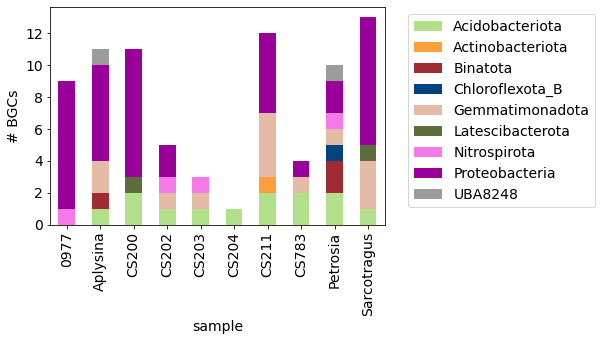

In [146]:
final_final_CCC_figure_df = final_final_CCC_df.groupby(['sample', 'bgc_id','phylum']).size().reset_index()
final_final_CCC_figure_df = final_final_CCC_figure_df.groupby('sample')['phylum'].value_counts().to_frame()
final_final_CCC_figure_df = final_final_CCC_figure_df.rename(columns={'phylum':'# BGCs'})
final_final_CCC_figure_df.reset_index(inplace=True)
final_final_CCC_figure_df['phylum'] = final_final_CCC_figure_df['phylum'].str.split('p__', expand=True)[1]

# Need to use alphabetically-ordered hex-codes or make colormap object
final_final_CCC_figure_df.pivot(index='sample', columns='phylum').plot(kind='bar', y='# BGCs',
                stacked=True,
                color=['#b2df8a','#ff9e3d','#a02c33','#02437f','#e3bba6','#5d6d3c',
                    '#F47BE7','#990099','#9c9c9c'], fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), fontsize=14)
plt.ylabel('# BGCs', fontsize=14)
plt.xlabel('sample', fontsize=14)

# plt.savefig('/Users/vincentn/Documents/Papers_and_Talks/Sponge_paper_2020/CCC_RiPPs_by_sample_and_tax.pdf', bbox_inches='tight')

# color_map = {'Proteobacteria':"#990099",
#  'Acidobacteriota':"#b2df8a",
#  'Actinobacteriota':"#ff9e3d",
#  'Bacteroidota':"#33a02c",
#  'Binatota':"#a02c33",
#  'Bdellovibrionota':"#006633",
#  'Bdellovibrionota_B':"#a46502",
#  'Chloroflexota':"#e3a6c9",
#  'Chloroflexota_B':'#02437f',
#  'Crenarchaeota':'#009999',
#  'Cyanobacteria':"#cab2d6",
#  'Dadabacteria':"#a561ed",
#  'Deinococcota':"#1f78b4",
#  'Gemmatimonadota':'#e3bba6',
#  'Latescibacterota':'#5d6d3c',
#  'Nitrospirota':"#F47BE7",
#  'Patescibacteria':"#dcdc23", 
#  'Poribacteria':"#e84f51",
#  'Spirochaetota':"#fb9a99",
#  'Tectomicrobia':"#000000",
#  'Verrucomicrobiota':'#a6cee3',
#  'UBA8248':"#9c9c9c"}

In [147]:
final_final_CCC_df['name_x'].value_counts()

NHase_alpha     111
AS-TIGR03793     30
Name: name_x, dtype: int64

In [148]:
list_1 = final_final_CCC_df['aa_seq'].str.split('AG', expand=True)[1].tolist()
list_2 = final_final_CCC_df['aa_seq'].str.split('AG', expand=True)[2].tolist()
list_3 = final_final_CCC_df['aa_seq'].str.split('AG', expand=True)[3].tolist()
overall_list = list_1+list_2+list_3
overall_output_list = []
RiPP_count = 0
for i in overall_list:
    if i == None:
        continue
    elif len(i) < 4:
        continue
    elif len(i) > 6:
        continue
    else:
        overall_output_list.append(i)
        RiPP_count += 1
        
print(RiPP_count)

141


In [149]:
np.unique(overall_output_list)

array(['FCCCI', 'LCCCF', 'LCCCG', 'LCCCGF', 'LCCCGI', 'LCCCGL', 'LCCCGV',
       'LCCCI', 'LCCCL', 'LCCCW', 'LSCCG', 'LSCCL', 'LSCCW', 'MCCCGI',
       'MCCCL', 'RCCC', 'RCCCCA', 'RCCCSW'], dtype='<U6')